In [3]:
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
sys.path.append('/media/moraa/New Volume/Ontita/10Academy/Cohort B/Projects/Week1/User_Analytics_in_the_telecommunication_Industry')

from dotenv import load_dotenv
from utils.db_connections import DBConnection
from utils.clean import DataCleaner
# from utils.plots import plot_distribution, plot_boxplot, plot_heatmap, plot_countplot, plot_histplot
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [5]:
# Create an instance of DBConnection
db_conn = DBConnection()

# Specify the table name you want to read
table_name = 'xdr_data'

# Read data from the specified table into a DataFrame
df = db_conn.read_table_to_dataframe(table_name)

df.head()

Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   
2                D42335A  ...          19725661.0          14699576.0   
3                T21824A  ...          21388122.0          15146643.0   
4                D88865A  ...          15259380.0          18962873.0   

   Netflix DL (Bytes)  Netflix UL (Bytes)  Gaming DL (Bytes)  \
0           8198936.0           9656251.0        278082303.0   
1          18338413.0          17227132.0        608750074.0   
2          17587794.0           6163408.0        229584621.0   
3          13994646.0           1097942.0        799538153.0   
4          17124581.0            415218.0        527707248.0   

   Gaming UL (Bytes)  Other DL (Bytes)  Other UL (Bytes)  Total UL (Bytes)  \
0         14344150.0       171744450.0         8814393.0        36749741.0   
1          1170709.0       526904238.0        15055145.0        53800391.0   
2           395630.0       410692588.0         4215763.0        27883638.0   
3         10849722.0       749039933.0        12797283.0        43324218.0   
4          3529801.0       550709500.0        13910322.0        38542814.0   

   Total DL (Bytes)  
0       308879636.0  
1       653384965.0  
2       279807335.0  
3       846028530.0  
4       569138589.0  

[5 rows x 55 columns]

## Data Preprocessing

Handling Missing Values

In [6]:
# Create an instance of DataCleaner
cleaner = DataCleaner()

# Remove columns with missing values exceeding the threshold
df = cleaner.remove_columns_with_missing_values(df)

# Fill missing values in numerical columns
df = cleaner.fill_missing_values_numerical(df)

# Fill missing values in categorical columns
df = cleaner.fill_missing_values_categorical(df)


In [7]:

df.isnull().sum()

Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

In [8]:
# Select numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64'])

# Print numerical columns
print("Numerical Columns:")
print(numerical_cols)

Numerical Columns:
           Bearer Id  Start ms     End ms     Dur. (ms)          IMSI  \
0       1.311448e+19  770.0000  662.00000  1.823652e+06  2.082014e+14   
1       1.311448e+19  235.0000  606.00000  1.365104e+06  2.082019e+14   
2       1.311448e+19    1.0000  652.00000  1.361762e+06  2.082003e+14   
3       1.311448e+19  486.0000  171.00000  1.321509e+06  2.082014e+14   
4       1.311448e+19  565.0000  954.00000  1.089009e+06  2.082014e+14   
...              ...       ...        ...           ...           ...   
149996  7.277826e+18  451.0000  214.00000  8.123000e+04  2.082022e+14   
149997  7.349883e+18  483.0000  187.00000  9.797000e+04  2.082019e+14   
149998  1.311448e+19  283.0000  810.00000  9.824900e+04  2.082017e+14   
149999  1.311448e+19  696.0000  327.00000  9.791000e+04  2.082021e+14   
150000  1.013887e+19  499.1882  498.80088  1.046086e+05  2.082016e+14   

        MSISDN/Number          IMEI  Avg RTT DL (ms)  Avg RTT UL (ms)  \
0        3.366496e+10  3.552121

In [9]:
# Select categorical columns
categorical_cols = df.select_dtypes(include=['object'])

# Print categorical columns
print("\nCategorical Columns:")
print(categorical_cols)


Categorical Columns:
                  Start              End     Last Location Name  \
0        4/4/2019 12:01  4/25/2019 14:35  9.16456699548519E+015   
1        4/9/2019 13:04   4/25/2019 8:15                L77566A   
2        4/9/2019 17:42  4/25/2019 11:58                D42335A   
3        4/10/2019 0:31   4/25/2019 7:36                T21824A   
4       4/12/2019 20:10  4/25/2019 10:40                D88865A   
...                 ...              ...                    ...   
149996   4/29/2019 7:28   4/30/2019 6:02                D20434A   
149997   4/29/2019 7:28  4/30/2019 10:41                D10223C   
149998   4/29/2019 7:28  4/30/2019 10:46                T51102A   
149999   4/29/2019 7:28  4/30/2019 10:40                L88342B   
150000   4/26/2019 7:25   4/25/2019 0:01                D41377B   

       Handset Manufacturer                 Handset Type  
0                   Samsung   Samsung Galaxy A5 Sm-A520F  
1                   Samsung  Samsung Galaxy J5 (Sm-J530

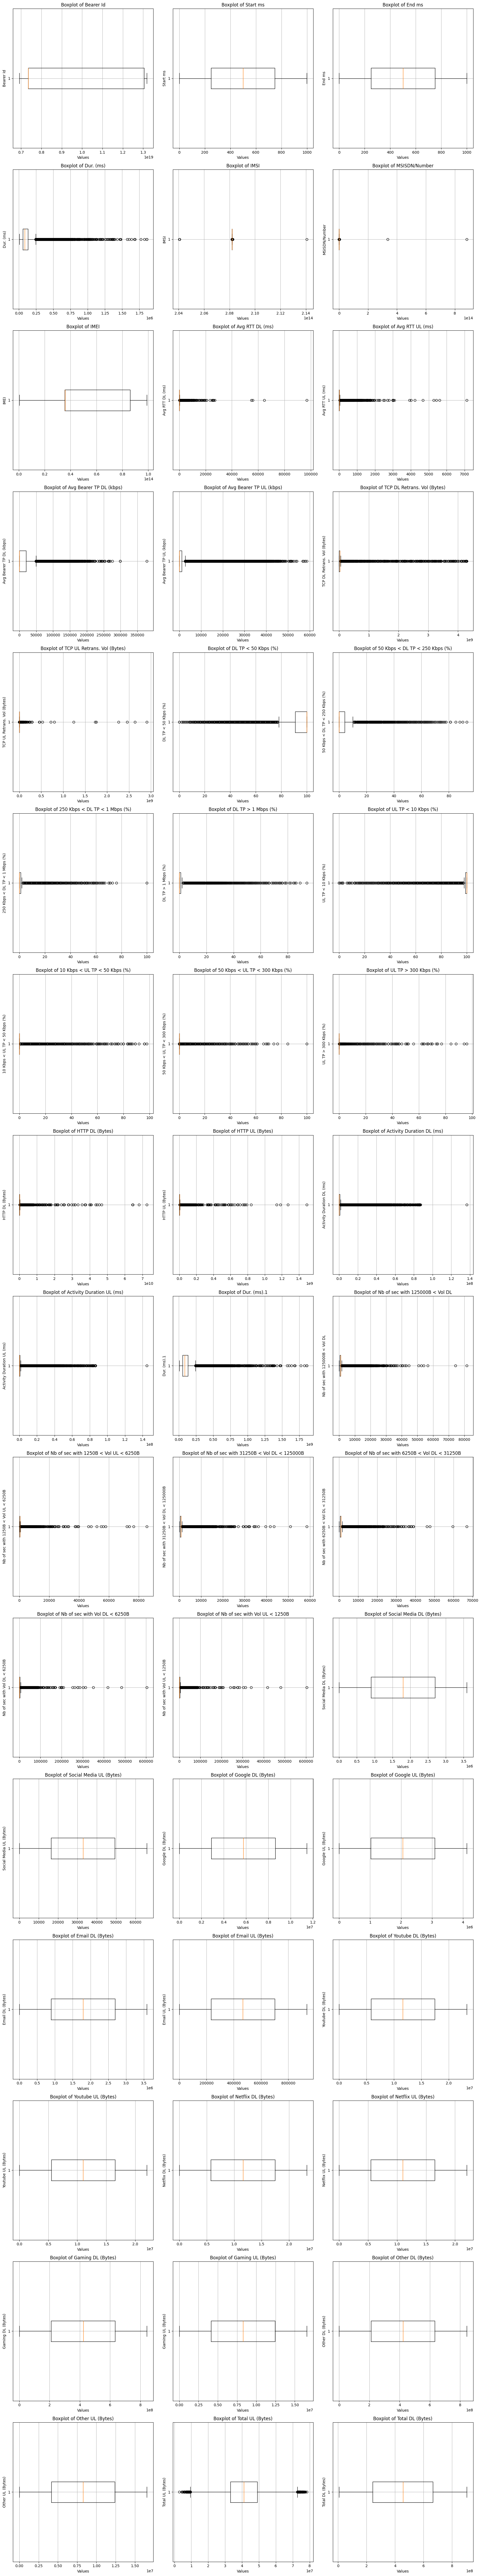

In [10]:
# Calculate the number of rows and columns for subplots
num_cols = len(numerical_cols.columns)
num_rows = (num_cols + 2) // 3  # Adjust as needed

# Create boxplots for each numerical column
plt.figure(figsize=(18, num_rows * 6))  # Adjust the figure height based on the number of rows
for i, col in enumerate(numerical_cols.columns):
    plt.subplot(num_rows, 3, i+1)  # Adjust the subplot layout
    plt.boxplot(df[col], vert=False)
    plt.title('Boxplot of ' + col)
    plt.xlabel('Values')
    plt.ylabel(col)
    plt.grid(True)

plt.tight_layout()
plt.show()

User Overview Analysis

In [11]:
# Compute Dispersion Parameters
dispersion_params = {}
for col in numerical_cols.columns:
    data = numerical_cols[col]
    # Range
    data_range = data.max() - data.min()
    # Variance
    data_variance = data.var()
    # Standard Deviation
    data_std_dev = data.std()
    # Interquartile Range (IQR)
    data_iqr = data.quantile(0.75) - data.quantile(0.25)
    
    dispersion_params[col] = {
        'Range': data_range,
        'Variance': data_variance,
        'Standard Deviation': data_std_dev,
        'Interquartile Range (IQR)': data_iqr
    }

# Interpretation
for col, params in dispersion_params.items():
    print(f"Dispersion Parameters for {col}:")
    print(params)

Dispersion Parameters for Bearer Id:
{'Range': 6.26900364859067e+18, 'Variance': 8.31514643133835e+36, 'Standard Deviation': 2.8835995615442775e+18, 'Interquartile Range (IQR)': 5.692542731480581e+18}
Dispersion Parameters for Start ms:
{'Range': 999.0, 'Variance': 83296.2355540933, 'Standard Deviation': 288.61087220354904, 'Interquartile Range (IQR)': 499.0}
Dispersion Parameters for End ms:
{'Range': 999.0, 'Variance': 82999.70444455891, 'Standard Deviation': 288.0966928733458, 'Interquartile Range (IQR)': 499.0}
Dispersion Parameters for Dur. (ms):
{'Range': 1852194.0, 'Variance': 6567052314.333346, 'Standard Deviation': 81037.35135314669, 'Interquartile Range (IQR)': 74988.0}
Dispersion Parameters for IMSI:
{'Range': 10027194860177.0, 'Variance': 4.5998344342438543e+20, 'Standard Deviation': 21447224608.894863, 'Interquartile Range (IQR)': 370342358.0}
Dispersion Parameters for MSISDN/Number:
{'Range': 882363507487729.0, 'Variance': 5.947410209613011e+24, 'Standard Deviation': 2438

Graphical Univariate Analysis

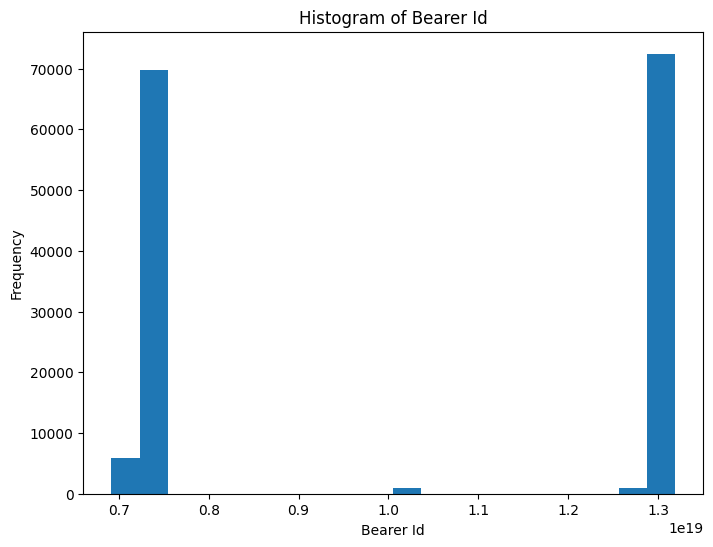

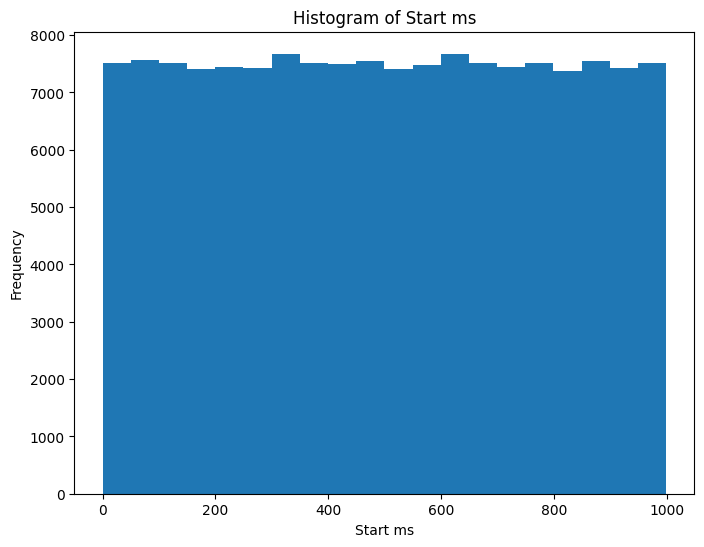

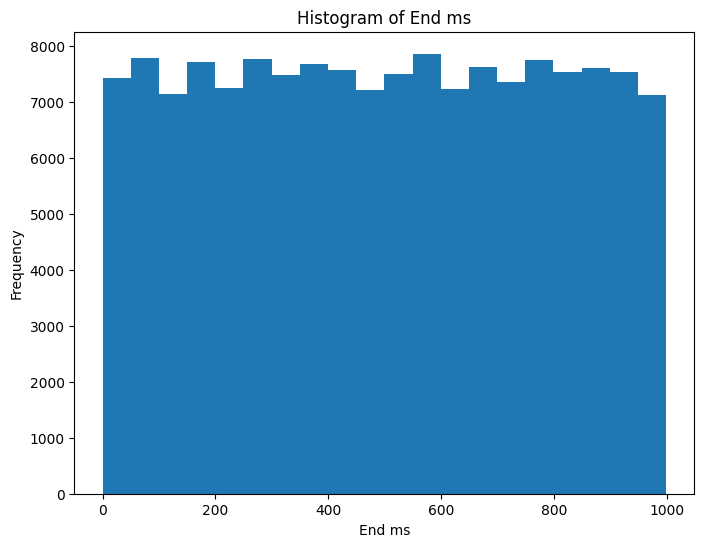

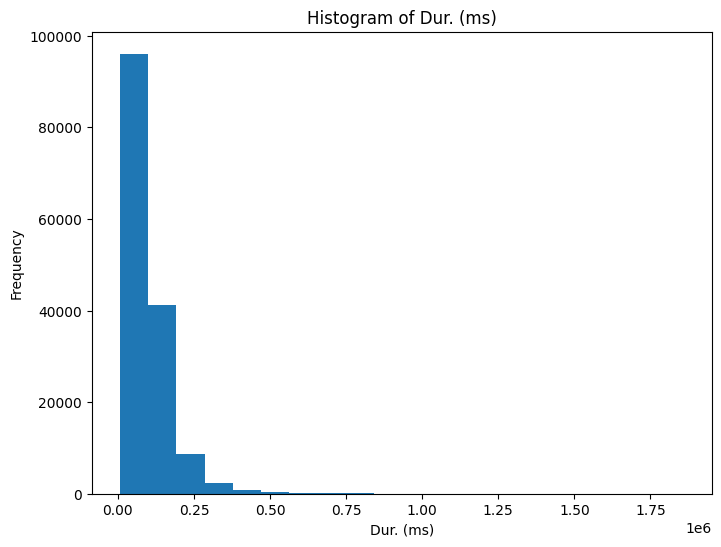

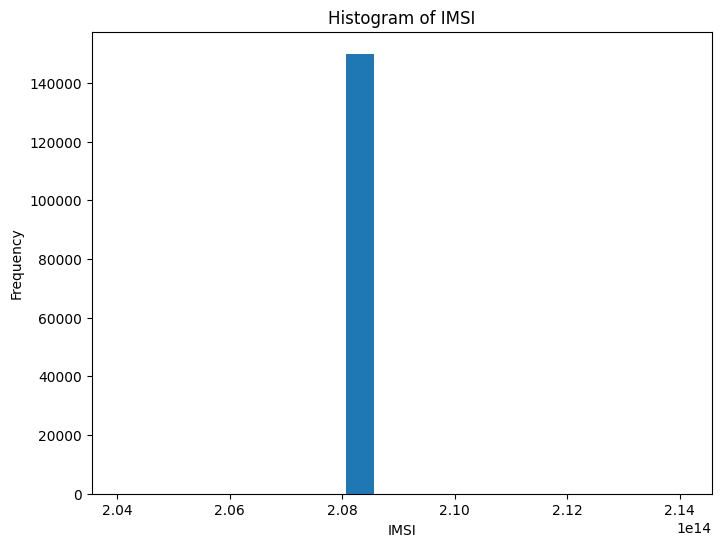

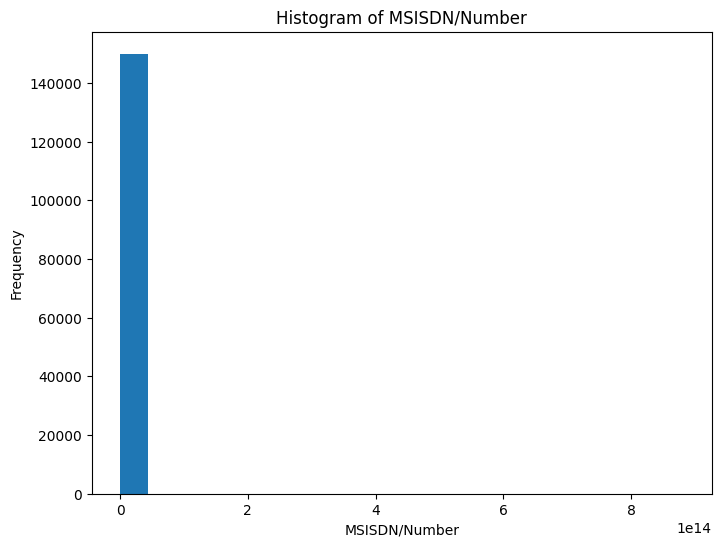

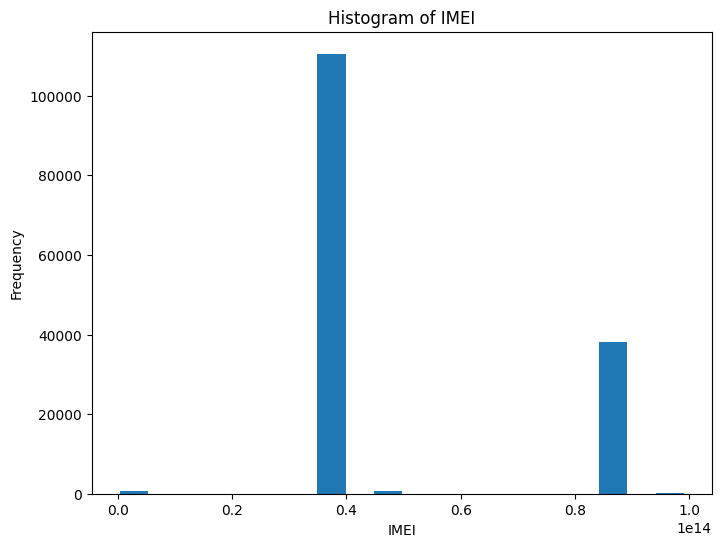

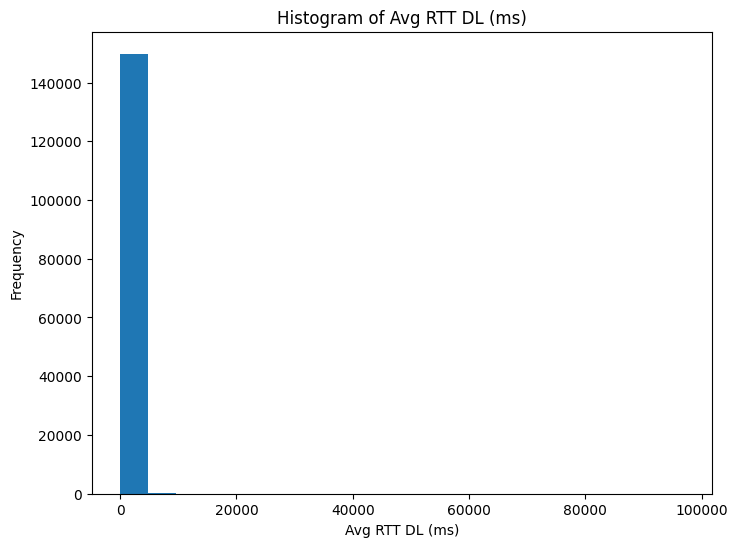

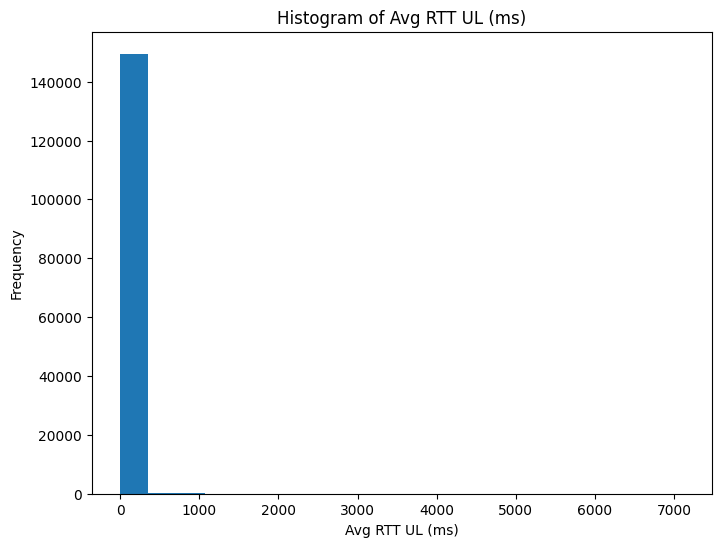

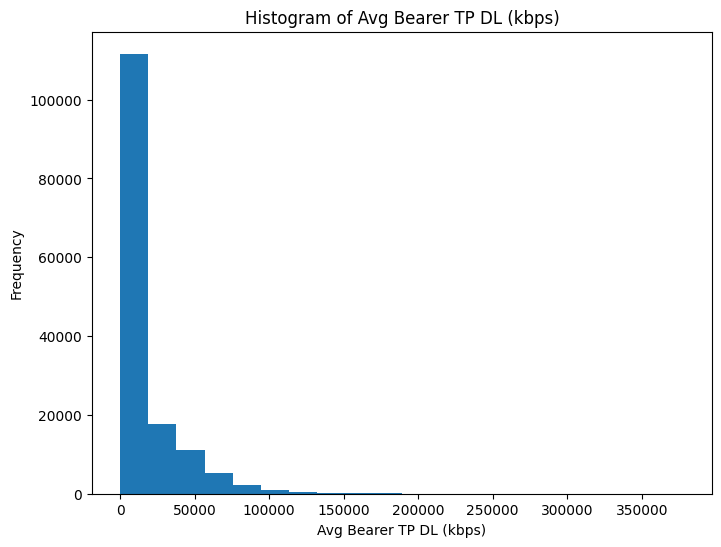

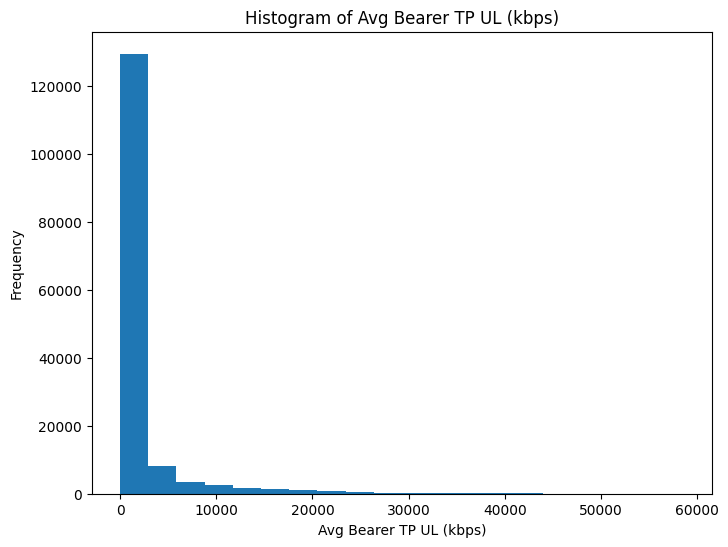

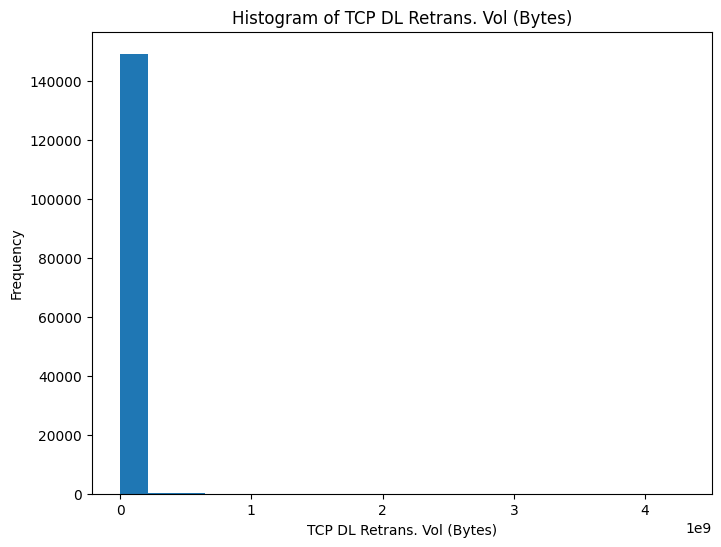

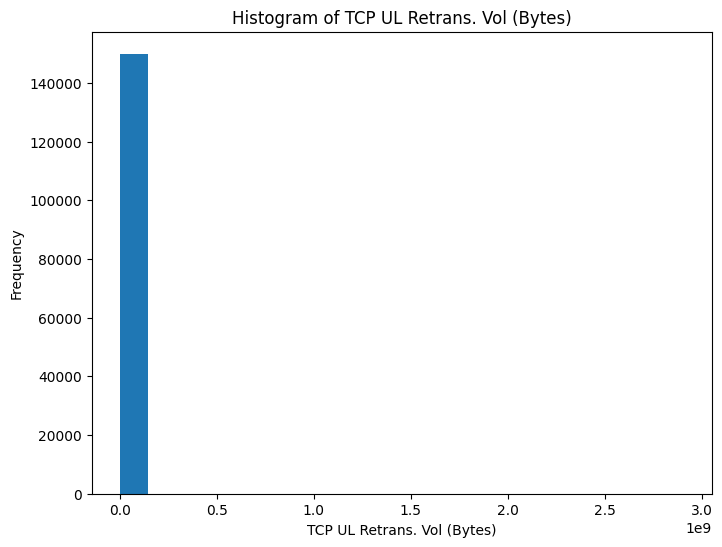

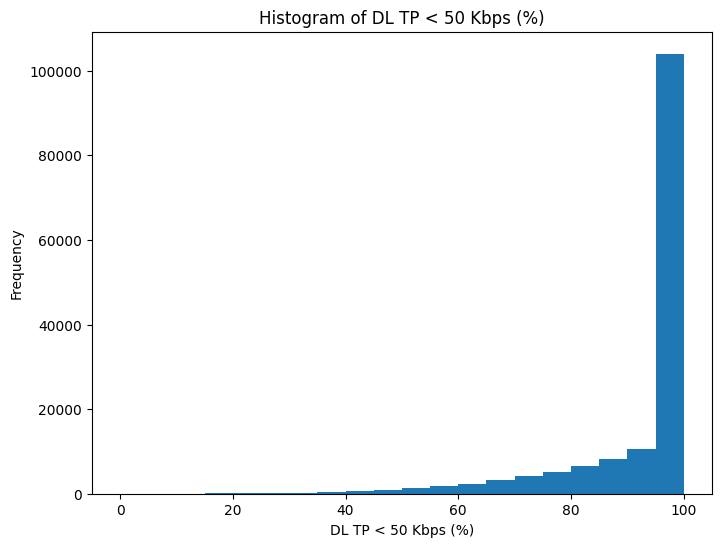

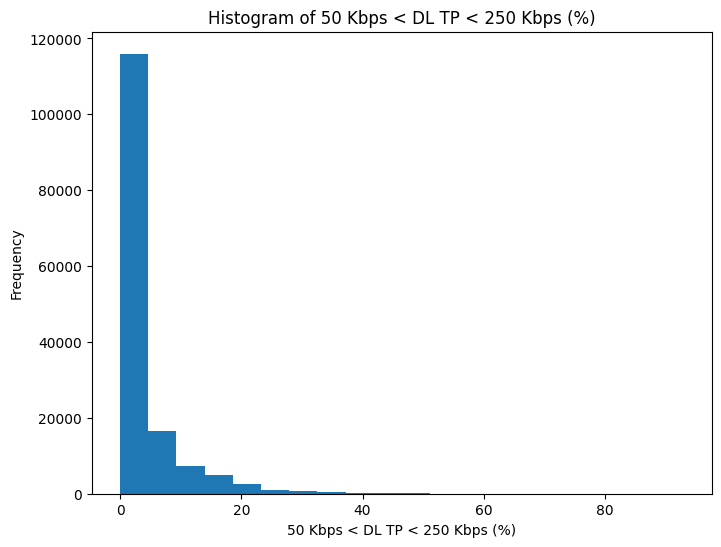

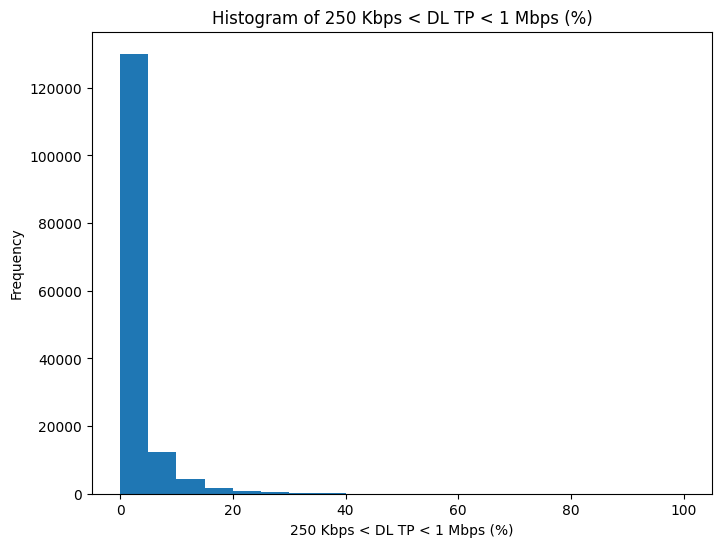

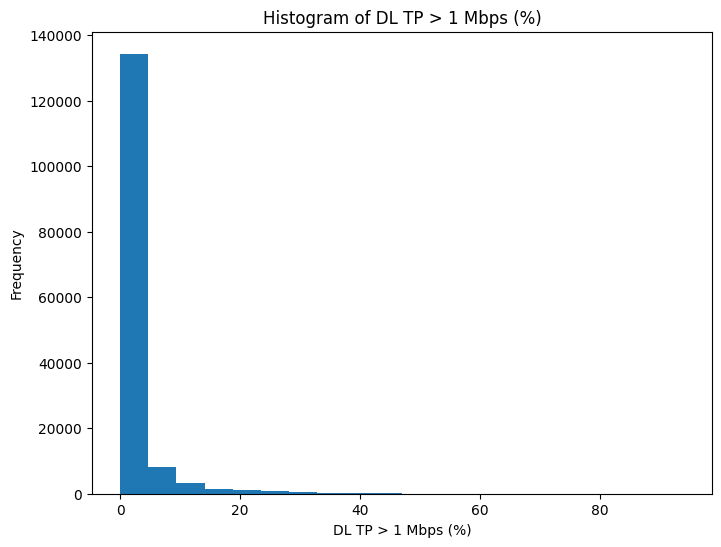

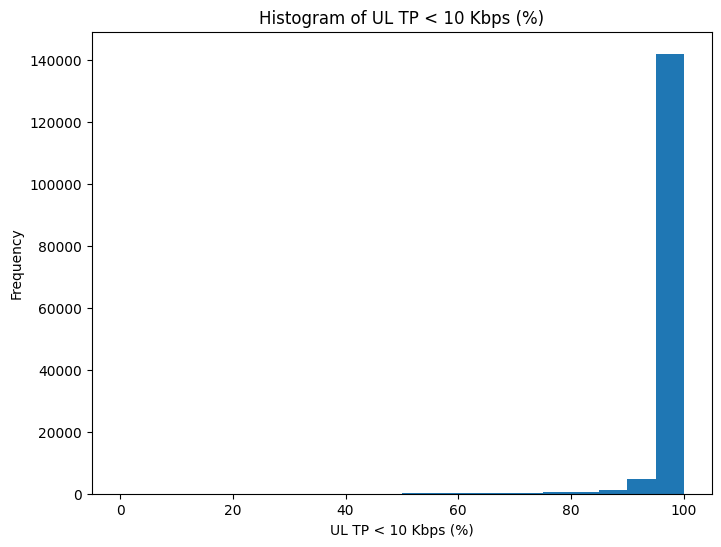

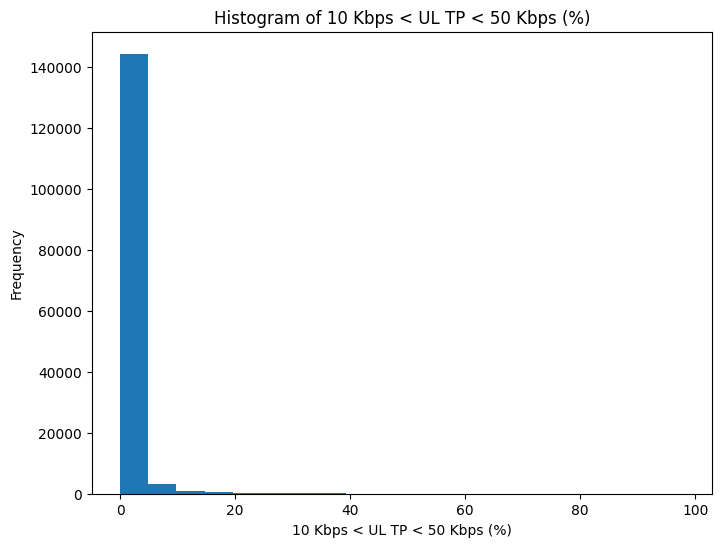

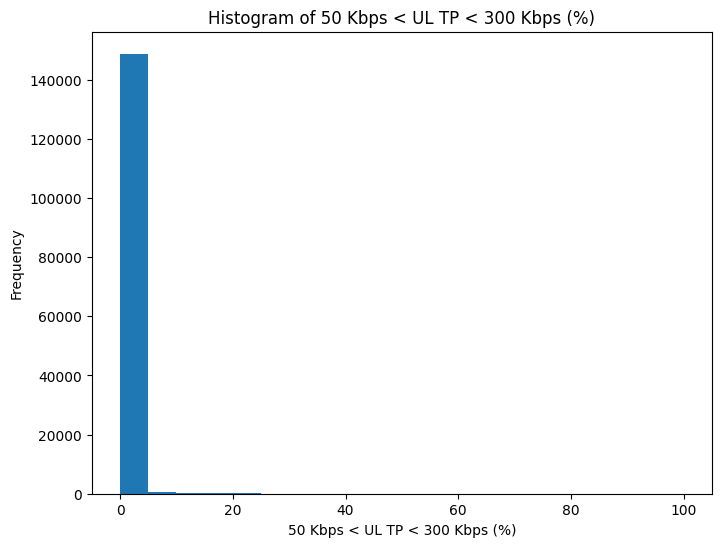

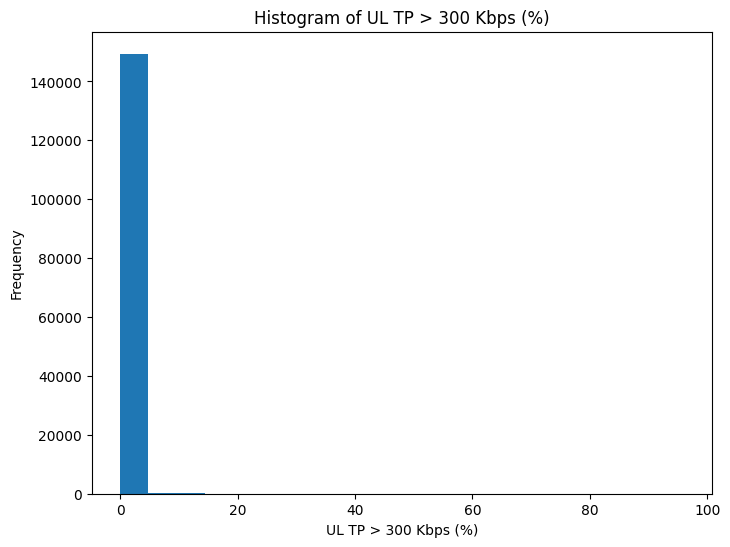

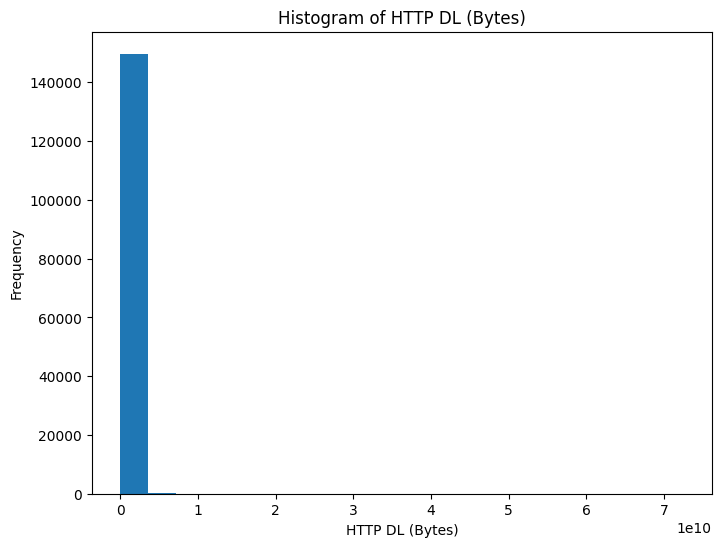

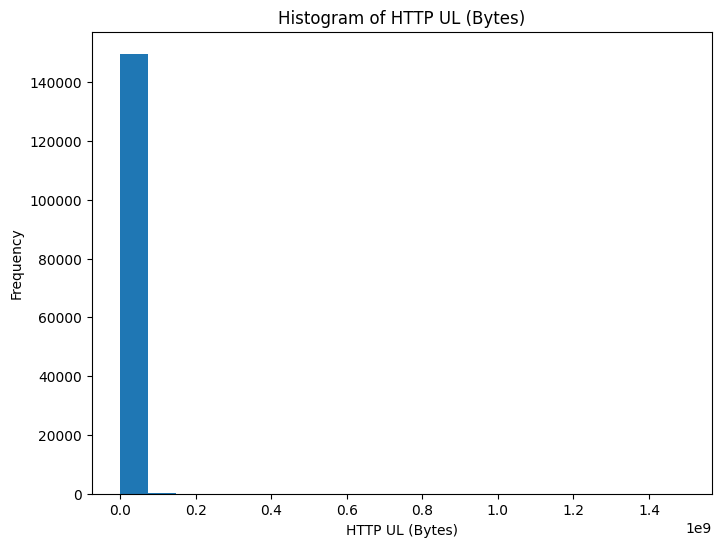

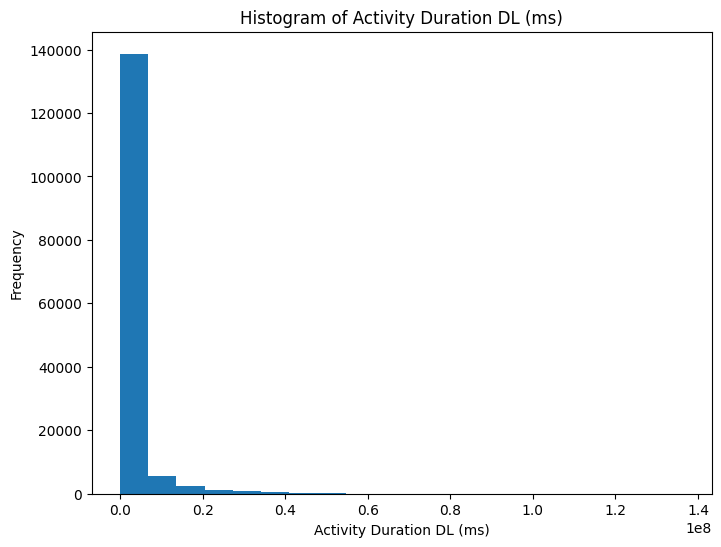

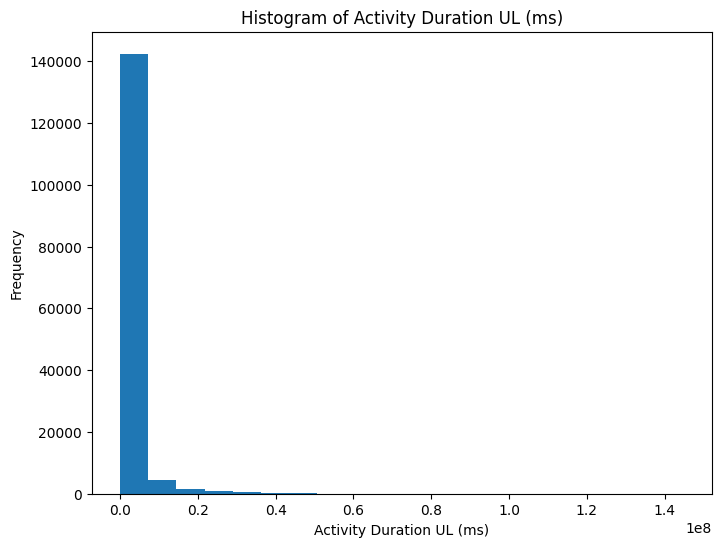

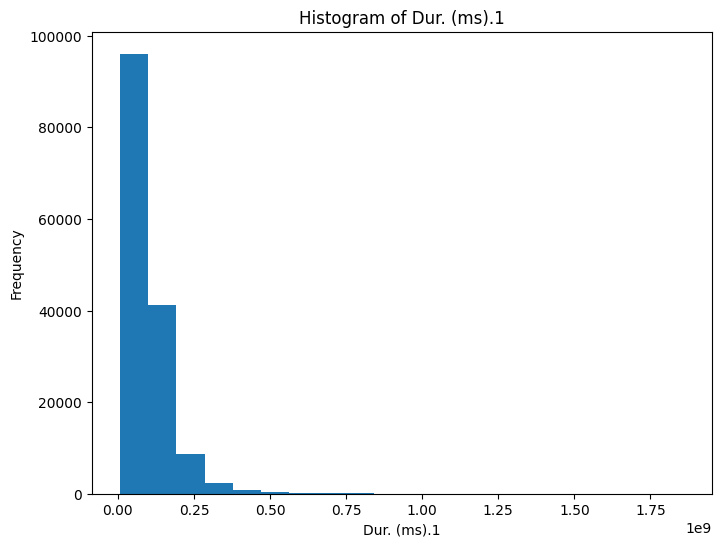

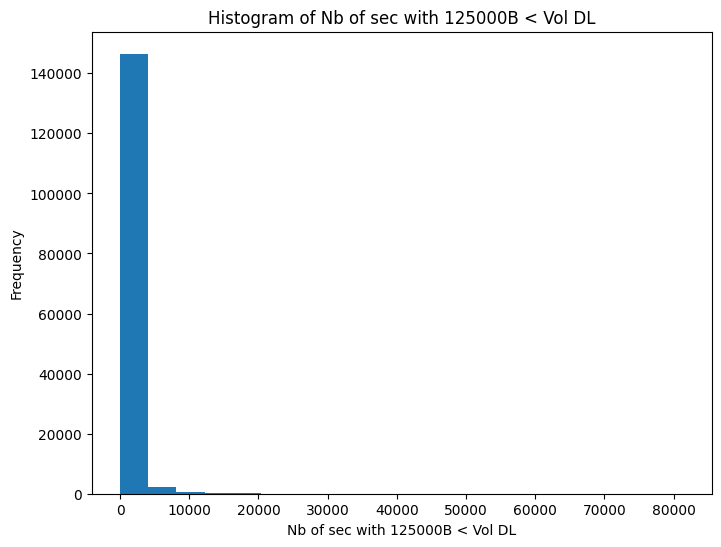

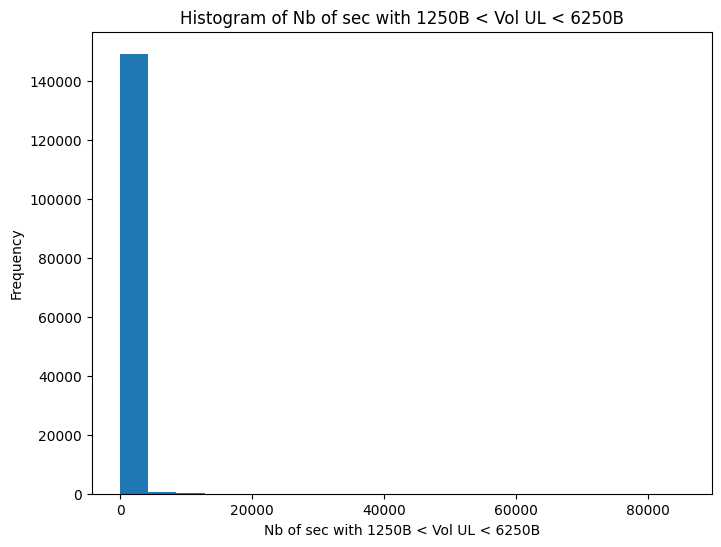

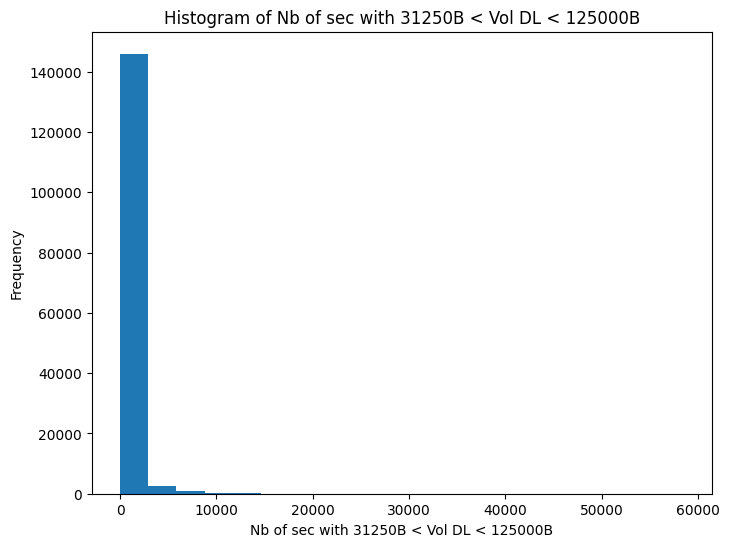

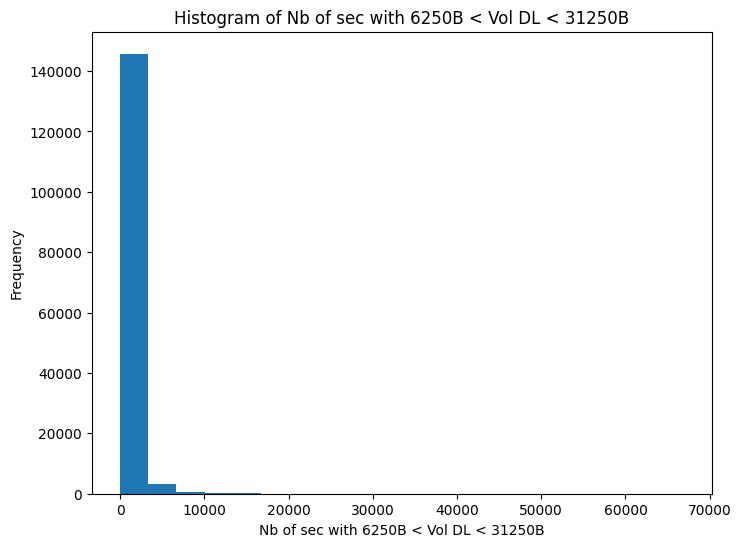

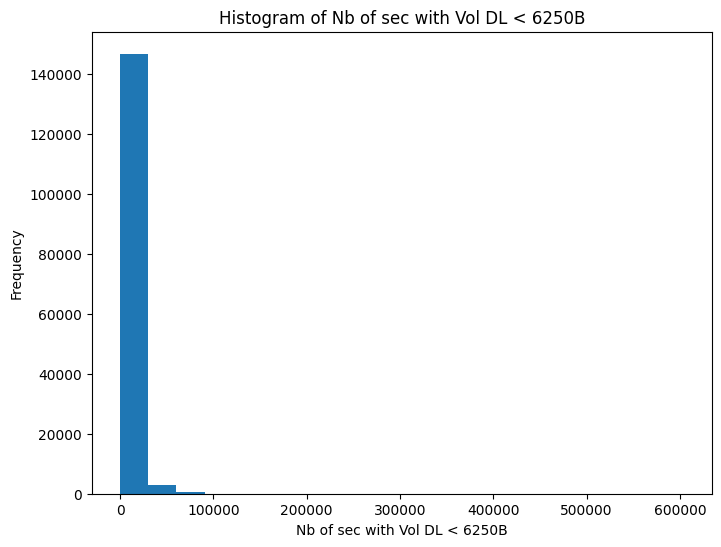

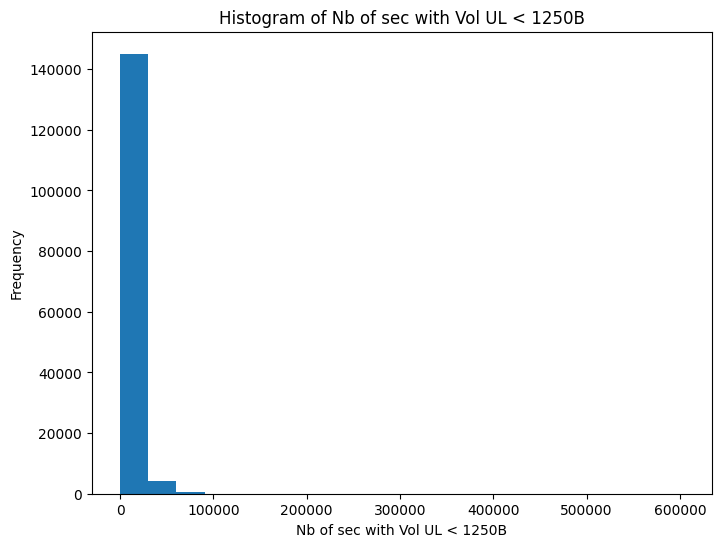

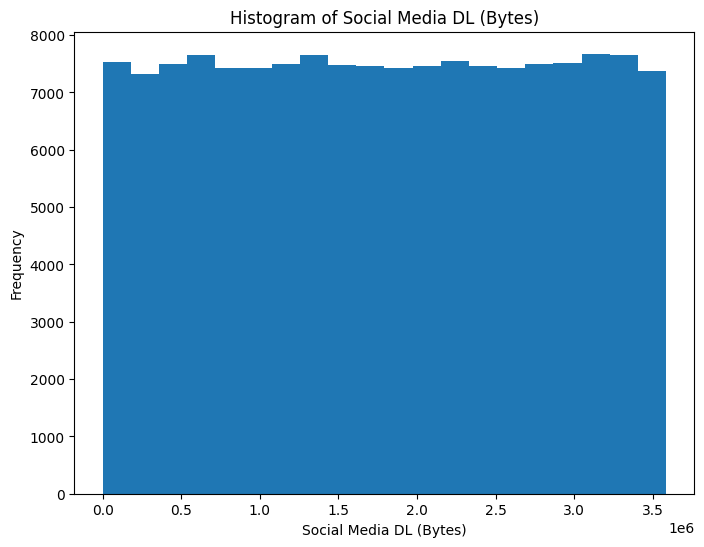

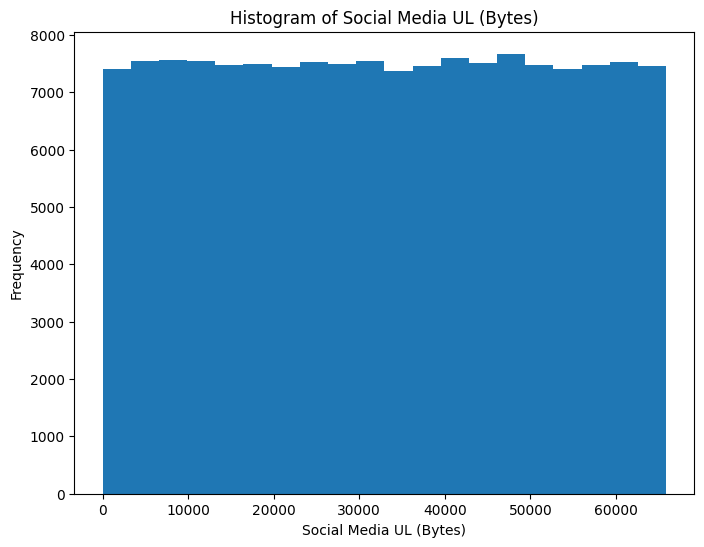

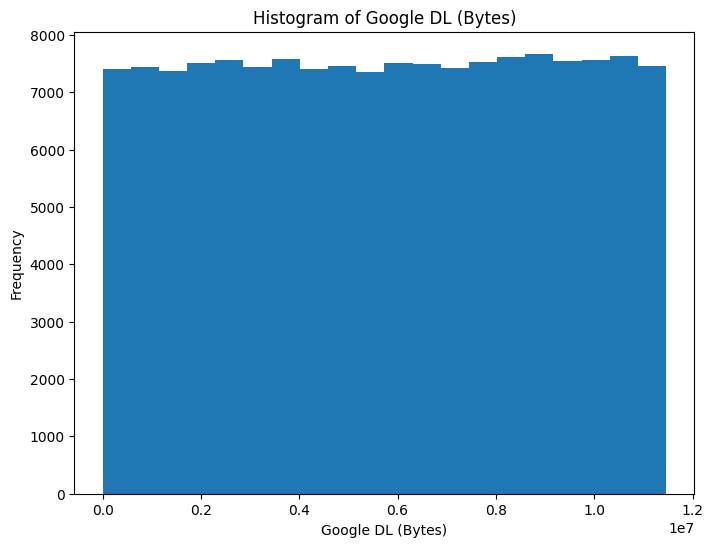

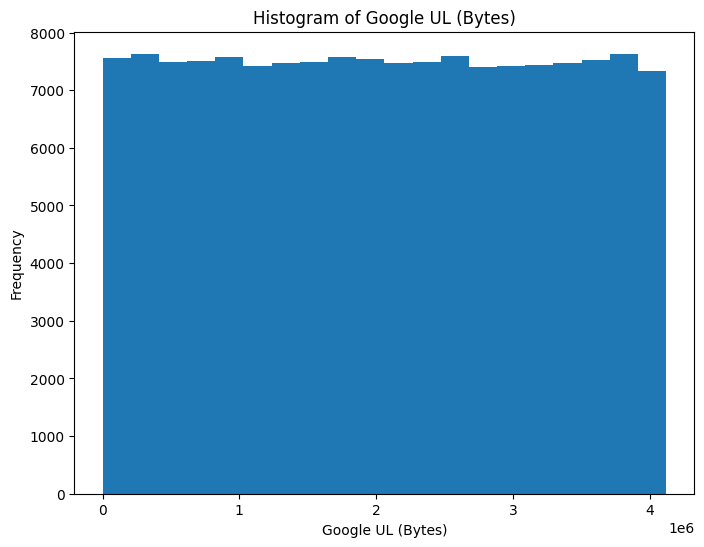

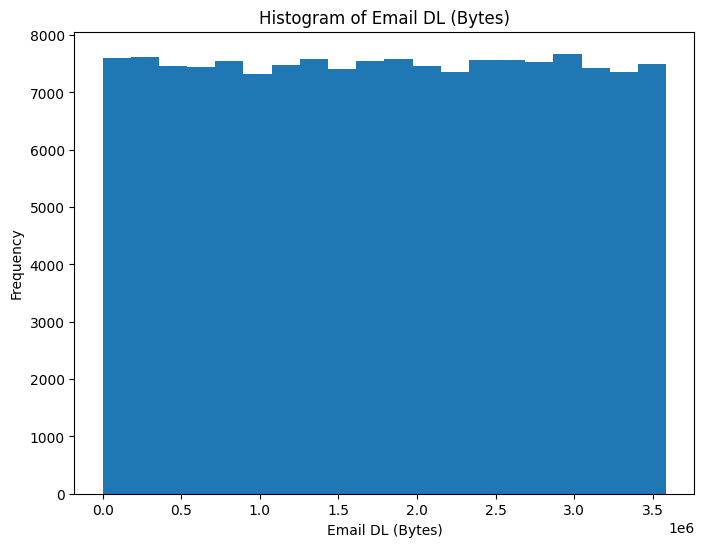

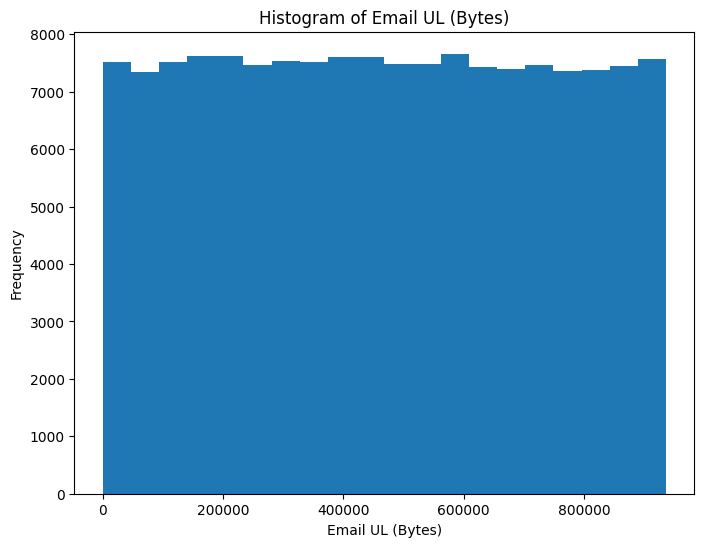

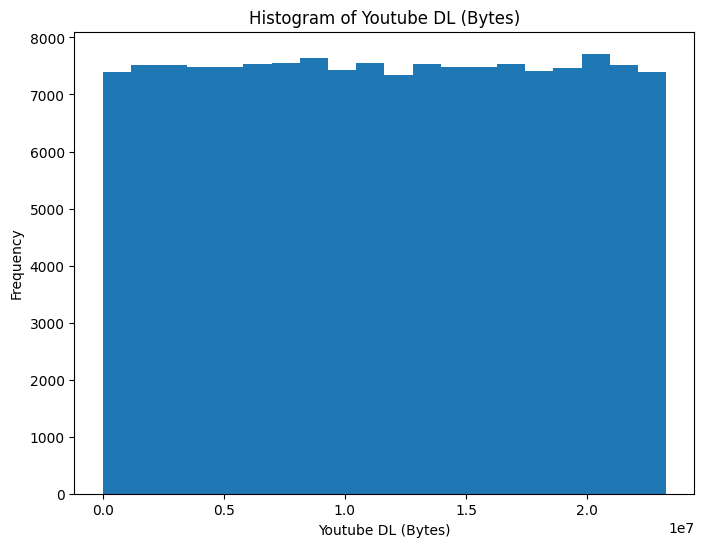

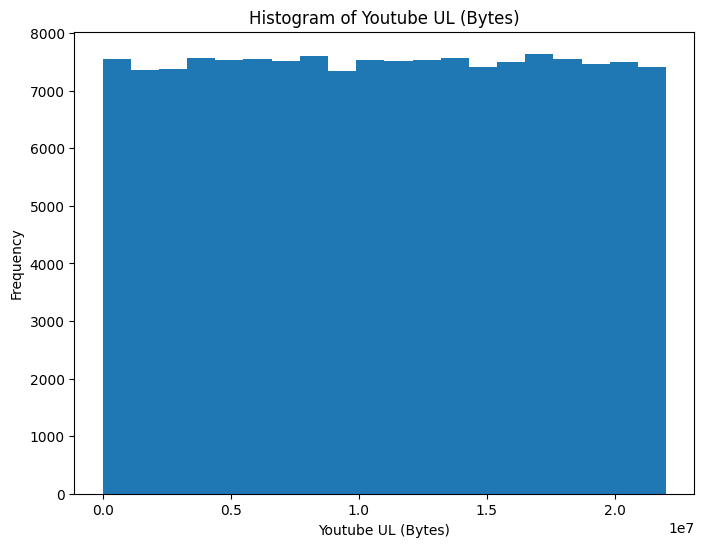

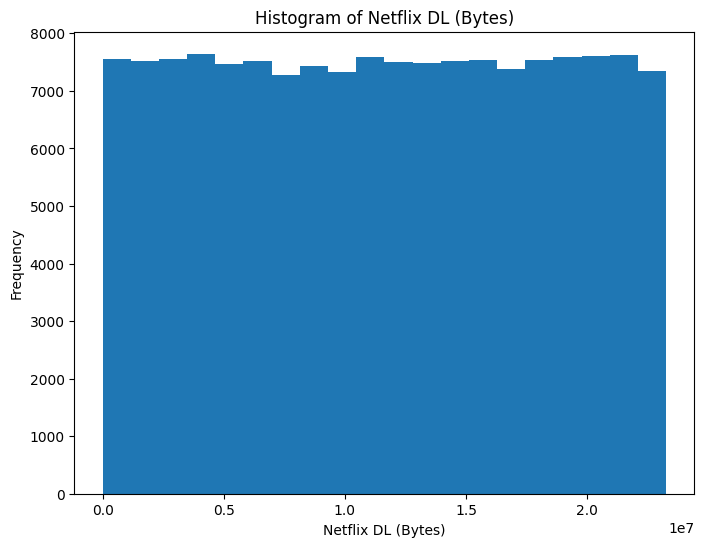

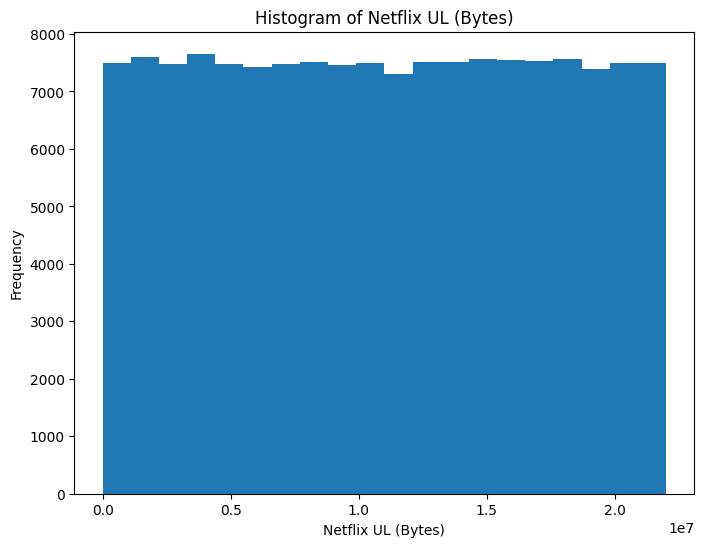

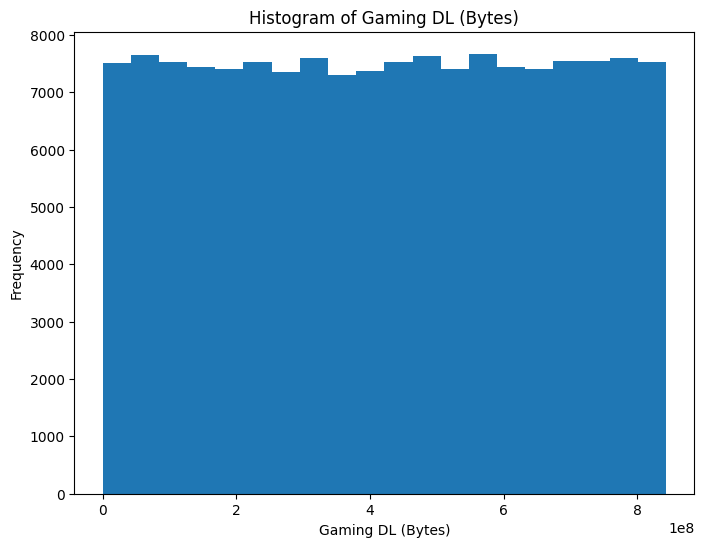

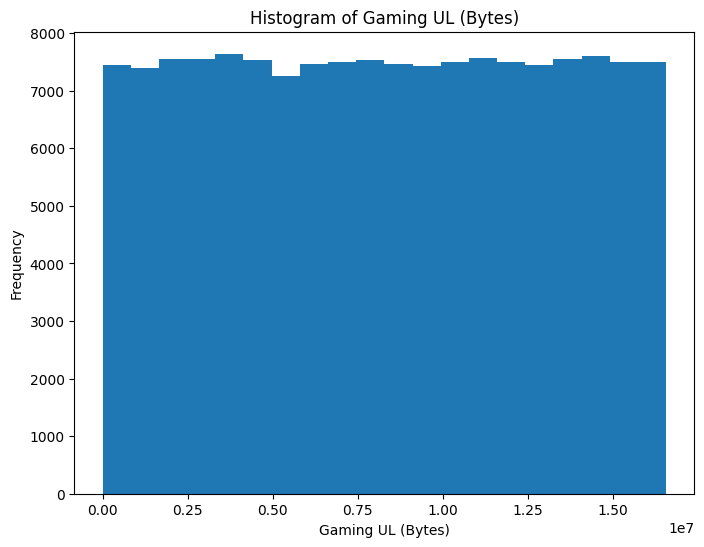

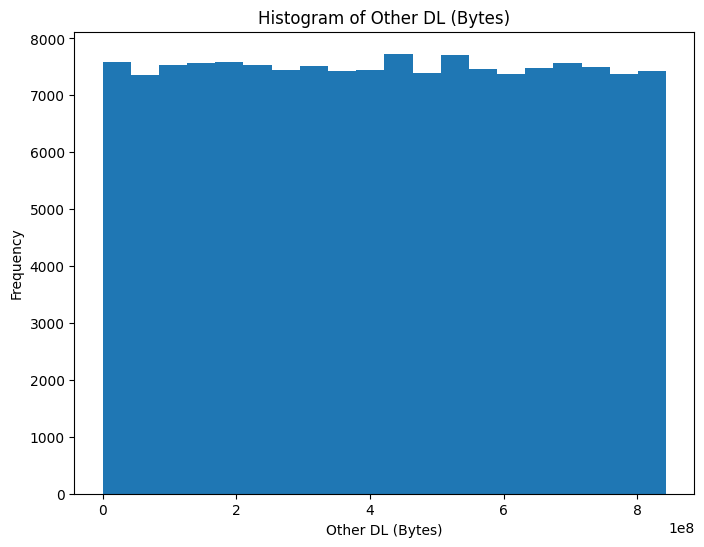

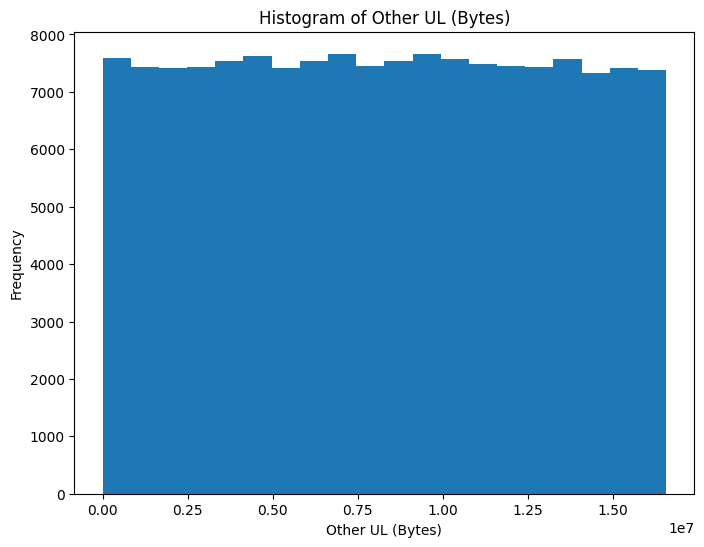

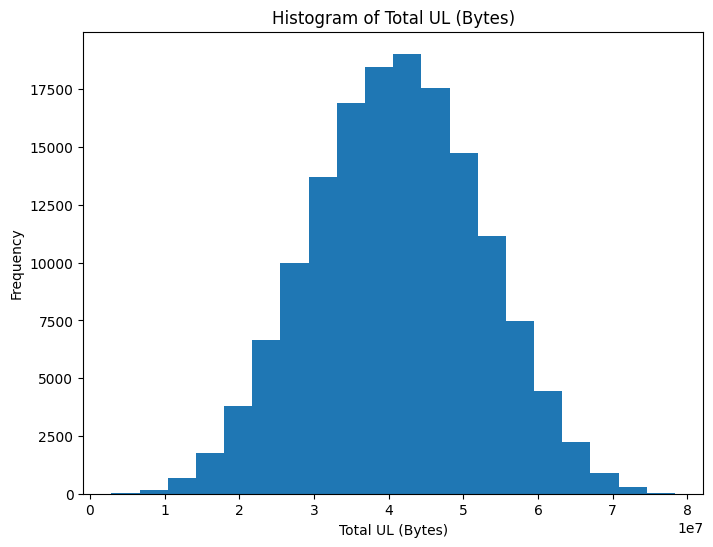

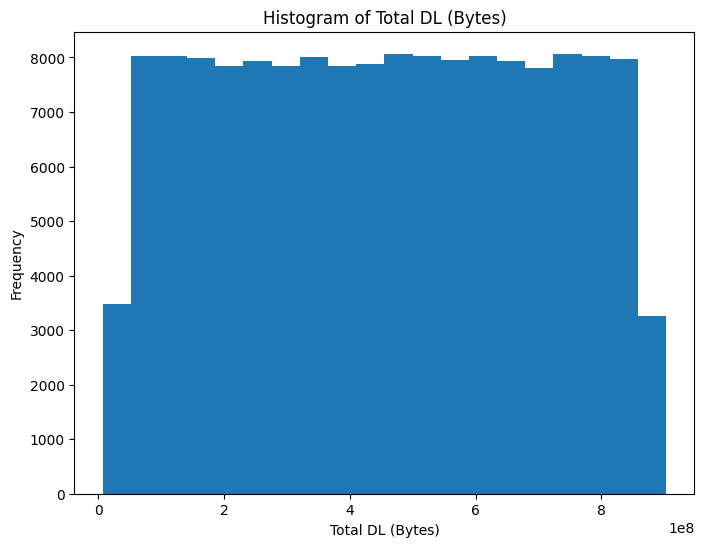

In [12]:
# Numeric columns
numeric_columns = df.select_dtypes(include=['float64']).columns

# Plotting histograms for each numeric variable
for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df[column], bins=20)  # Adjust the number of bins as needed
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

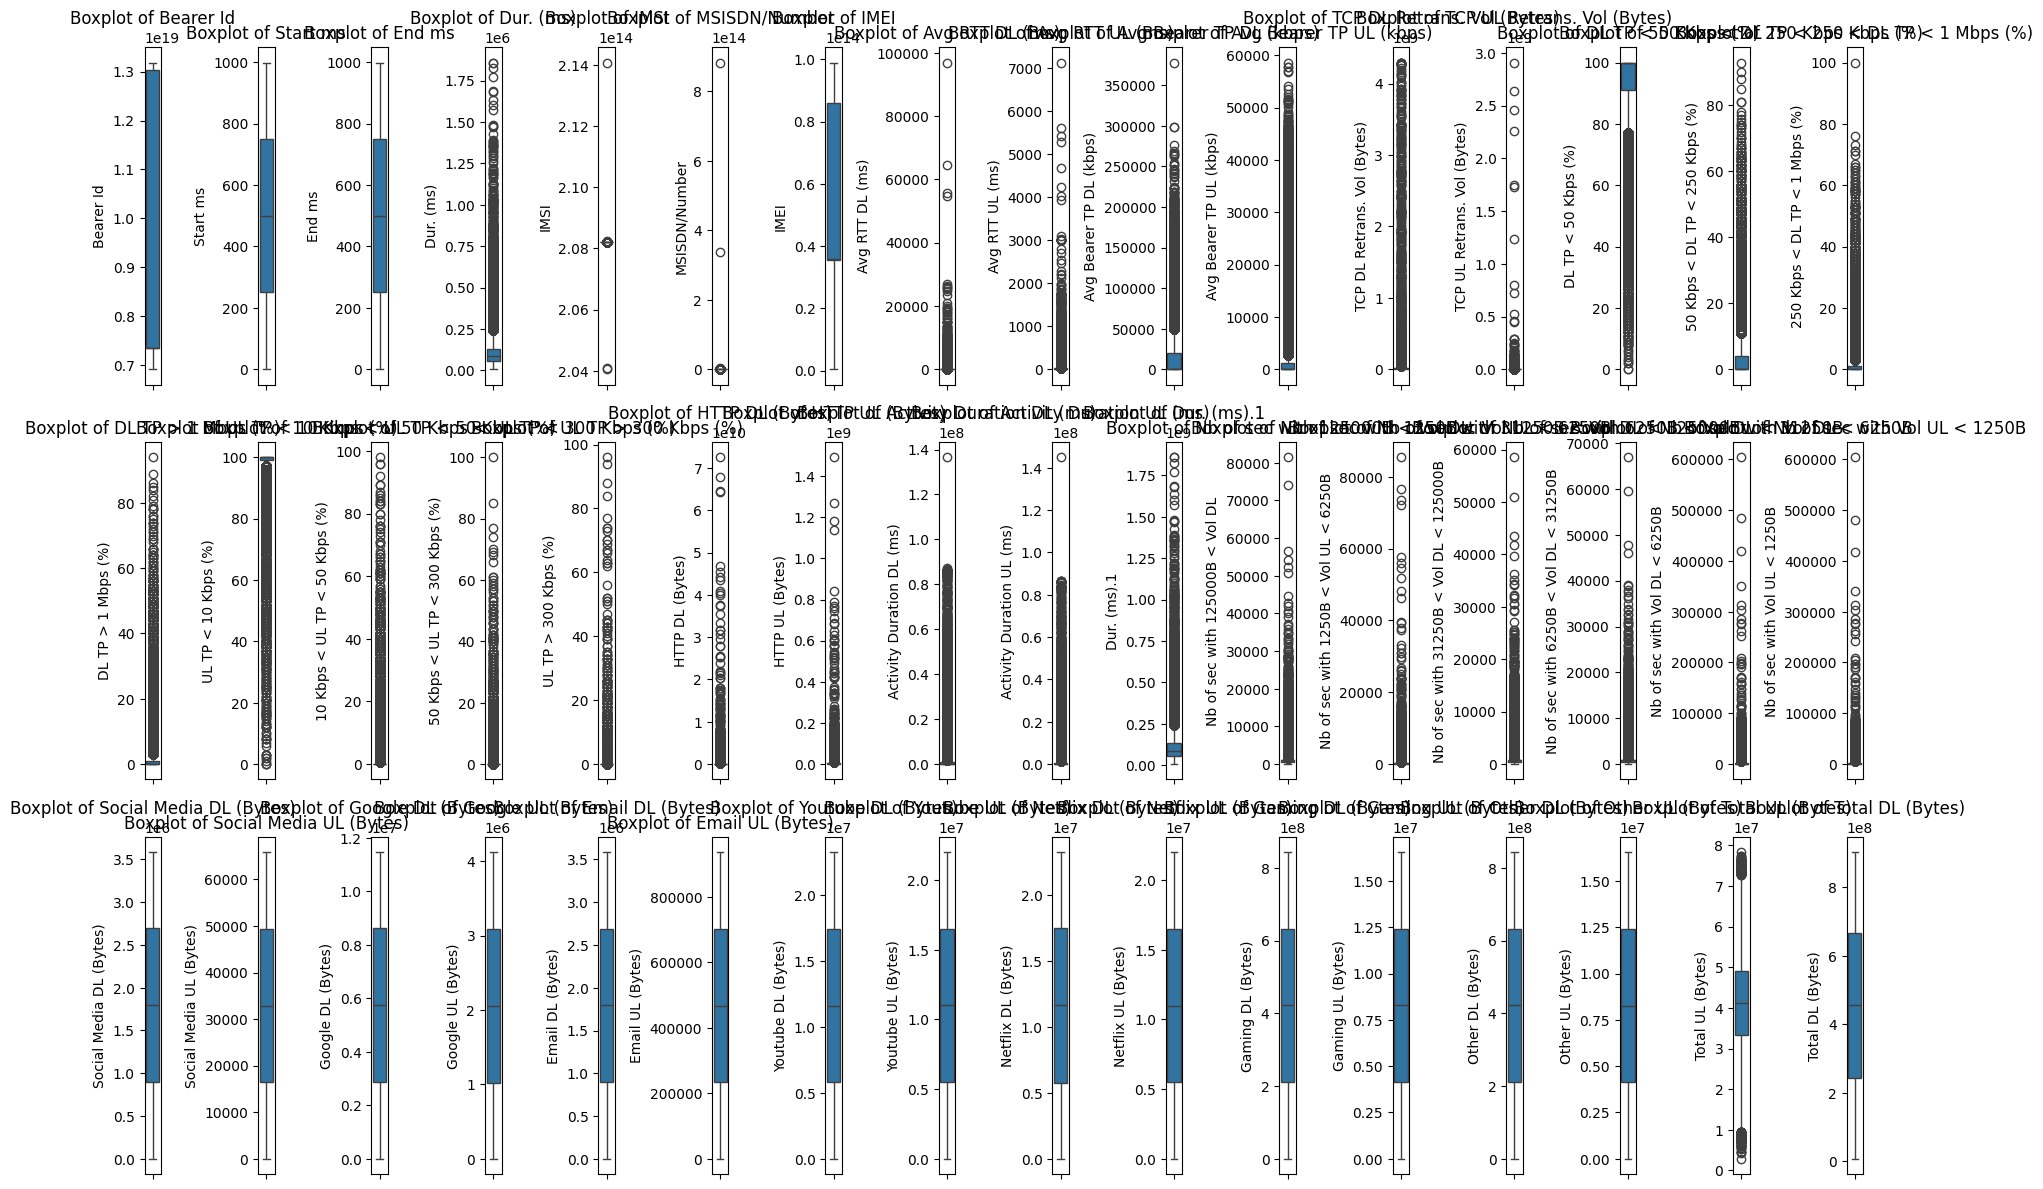

In [13]:
# Plot boxplots for numerical columns
plt.figure(figsize=(18, 12))  # Larger figsize
num_cols = len(numerical_cols.columns)
num_rows = (num_cols // 3) + (num_cols % 3 > 0)  # Calculate number of rows needed
for i, col in enumerate(numerical_cols.columns):
    plt.subplot(3, num_rows, i+1)
    sns.boxplot(y=numerical_cols[col])
    plt.title('Boxplot of ' + col)
plt.tight_layout()
plt.show()

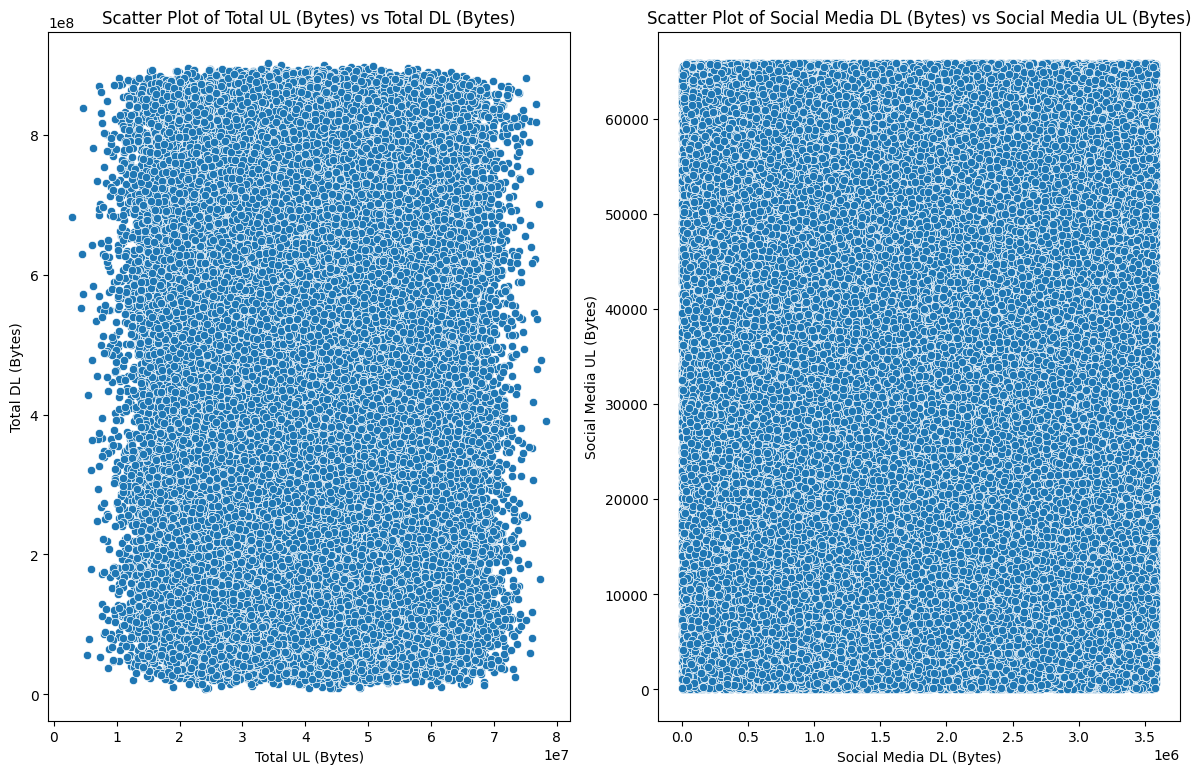

In [14]:
# Select pairs of quantitative columns for scatter plot visualization
quantitative_pairs = [('Total UL (Bytes)', 'Total DL (Bytes)'),
                      ('Social Media DL (Bytes)', 'Social Media UL (Bytes)')]

# Plot scatter plots for quantitative pairs
plt.figure(figsize=(12, 8))
for i, pair in enumerate(quantitative_pairs):
    plt.subplot(1, 2, i+1)
    sns.scatterplot(x=pair[0], y=pair[1], data=df)
    plt.title('Scatter Plot of ' + pair[0] + ' vs ' + pair[1])
plt.tight_layout()
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


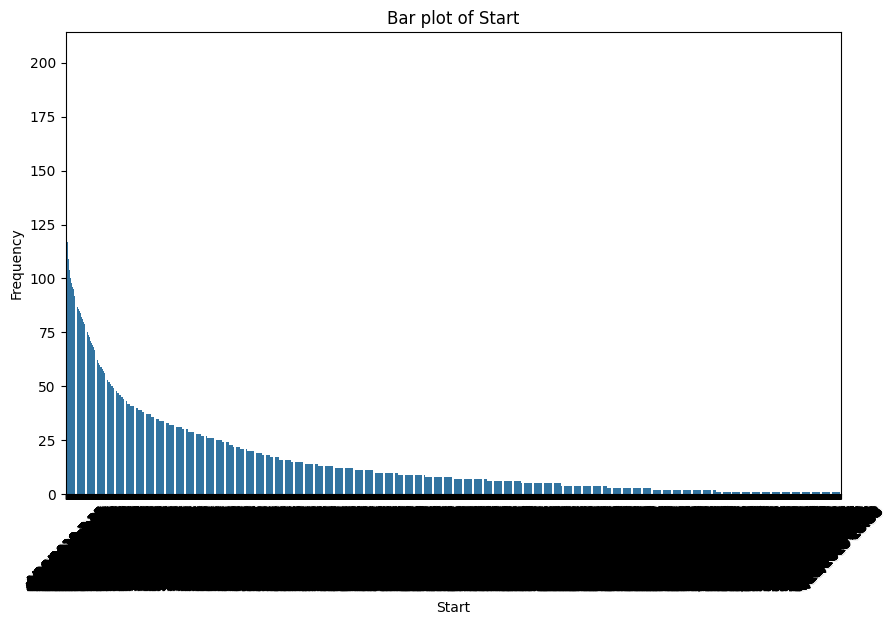

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


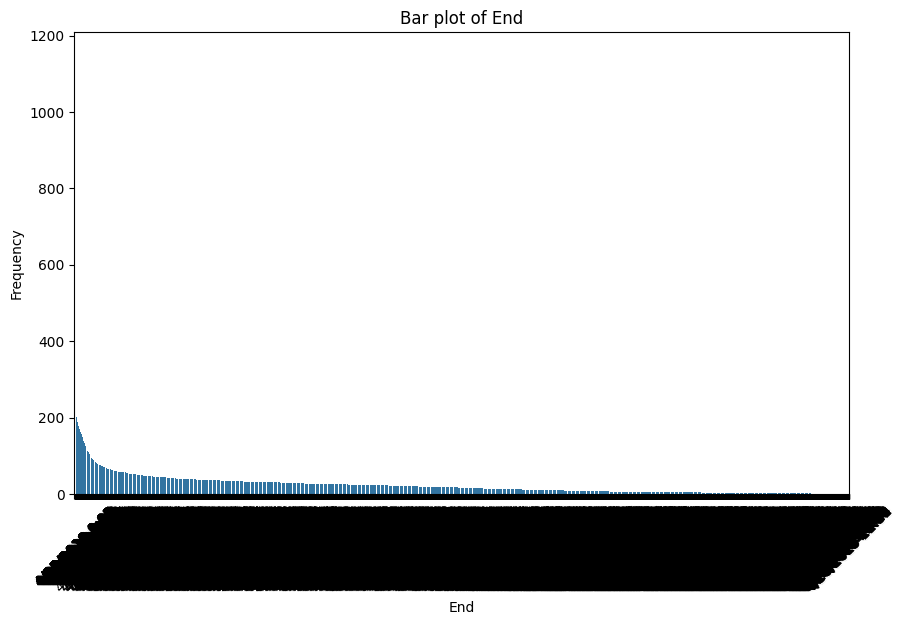

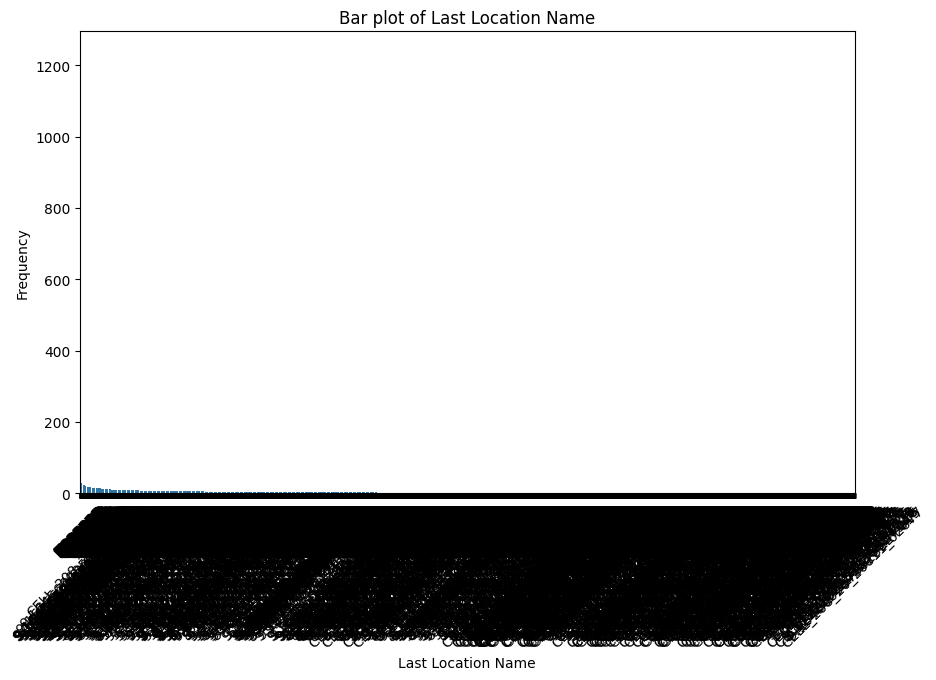

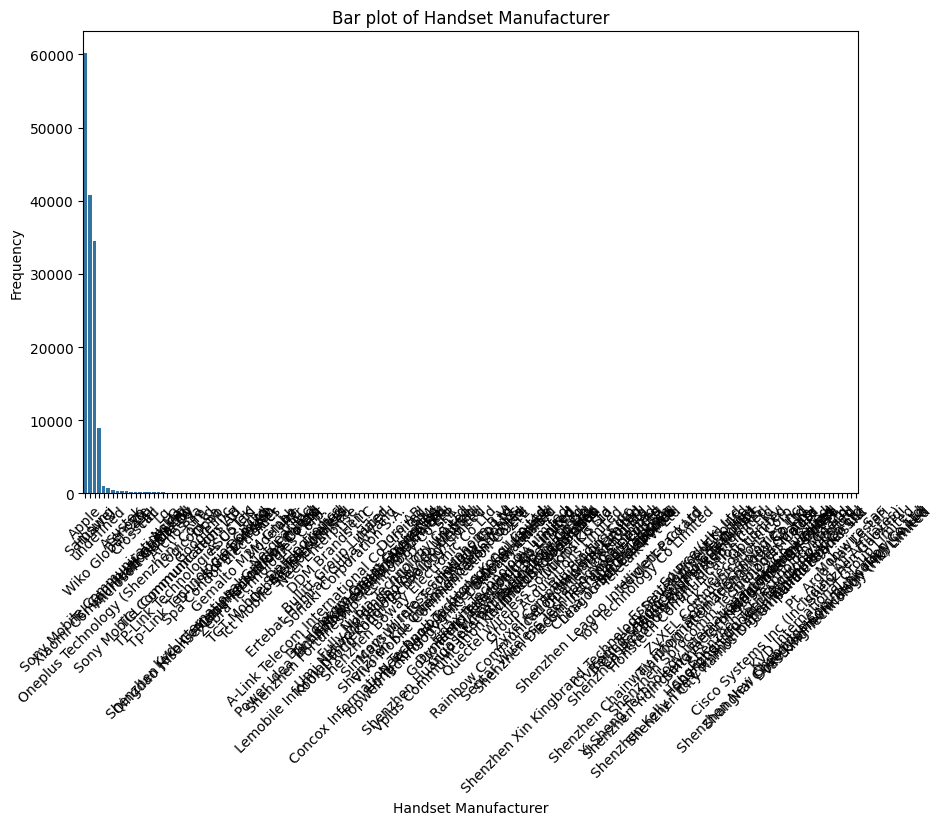

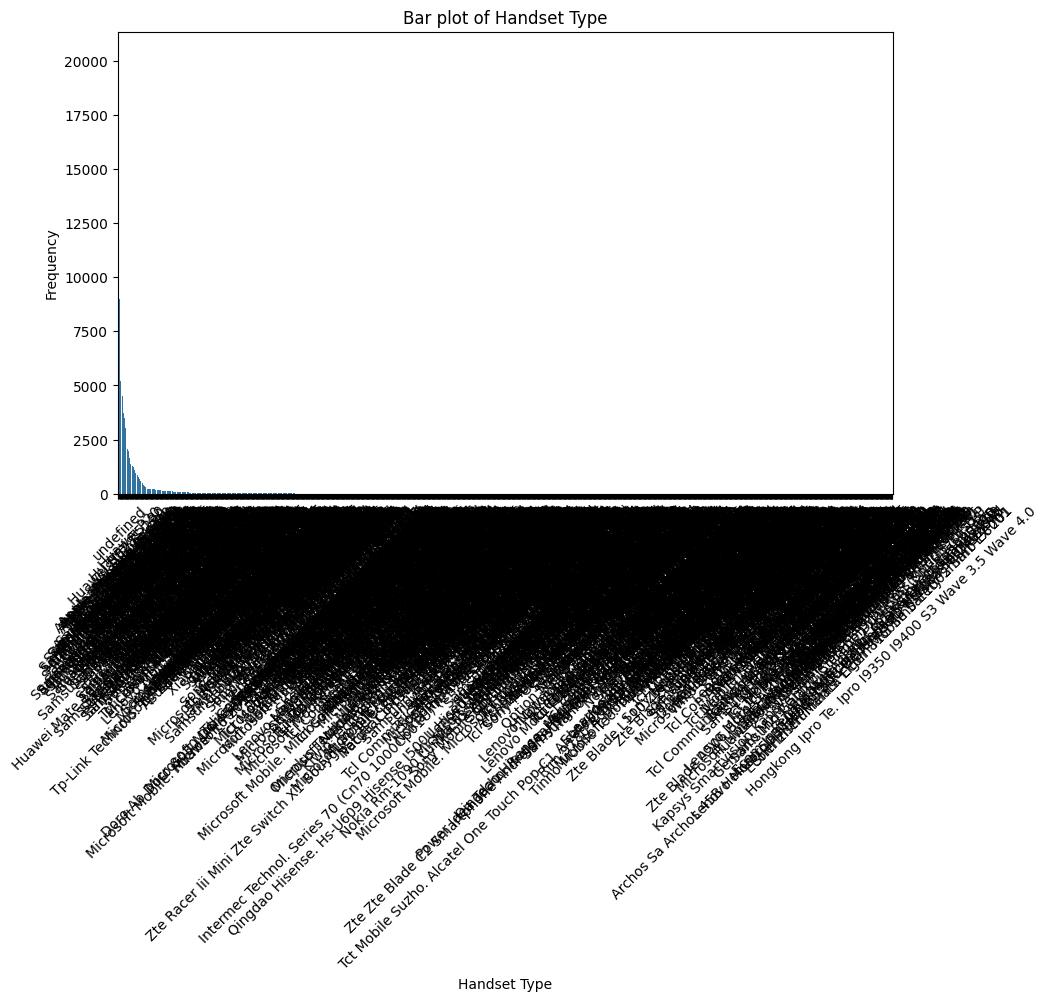

In [15]:

# Plotting bar plots for each categorical variable
for column in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column, order=df[column].value_counts().index)
    plt.title(f'Bar plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


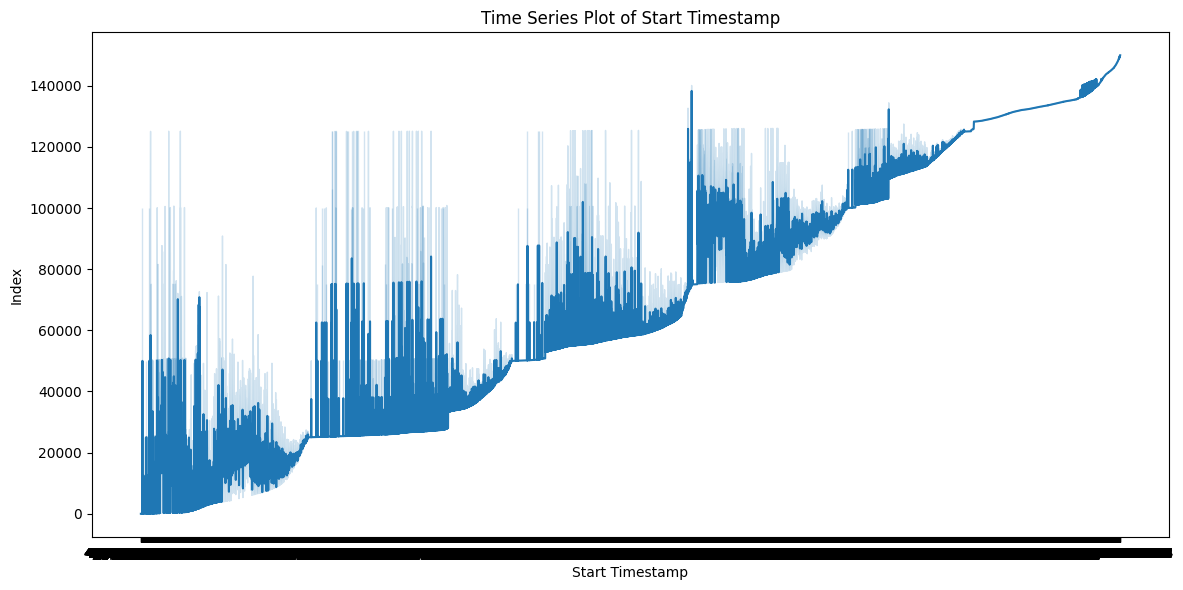

In [16]:
# Plot time series for 'Start' variable
plt.figure(figsize=(12, 6))
sns.lineplot(x=categorical_cols['Start'], y=categorical_cols.index, data=df)
plt.title('Time Series Plot of Start Timestamp')
plt.xlabel('Start Timestamp')
plt.ylabel('Index')
plt.tight_layout()
plt.show()


Bivariate Analysis

In [17]:
# Concatenate the two DataFrames along axis 1 (columns)
combined_df = pd.concat([categorical_cols, numerical_cols], axis=1)

combined_df.head()

Start              End     Last Location Name  \
0   4/4/2019 12:01  4/25/2019 14:35  9.16456699548519E+015   
1   4/9/2019 13:04   4/25/2019 8:15                L77566A   
2   4/9/2019 17:42  4/25/2019 11:58                D42335A   
3   4/10/2019 0:31   4/25/2019 7:36                T21824A   
4  4/12/2019 20:10  4/25/2019 10:40                D88865A   

  Handset Manufacturer                 Handset Type     Bearer Id  Start ms  \
0              Samsung   Samsung Galaxy A5 Sm-A520F  1.311448e+19     770.0   
1              Samsung  Samsung Galaxy J5 (Sm-J530)  1.311448e+19     235.0   
2              Samsung     Samsung Galaxy A8 (2018)  1.311448e+19       1.0   
3            undefined                    undefined  1.311448e+19     486.0   
4              Samsung             Samsung Sm-G390F  1.311448e+19     565.0   

   End ms  Dur. (ms)          IMSI  ...  Youtube DL (Bytes)  \
0   662.0  1823652.0  2.082014e+14  ...          15854611.0   
1   606.0  1365104.0  2.082019e+14  ...          20247395.0   
2   652.0  1361762.0  2.082003e+14  ...          19725661.0   
3   171.0  1321509.0  2.082014e+14  ...          21388122.0   
4   954.0  1089009.0  2.082014e+14  ...          15259380.0   

   Youtube UL (Bytes)  Netflix DL (Bytes)  Netflix UL (Bytes)  \
0           2501332.0           8198936.0           9656251.0   
1          19111729.0          18338413.0          17227132.0   
2          14699576.0          17587794.0           6163408.0   
3          15146643.0          13994646.0           1097942.0   
4          18962873.0          17124581.0            415218.0   

   Gaming DL (Bytes)  Gaming UL (Bytes)  Other DL (Bytes)  Other UL (Bytes)  \
0        278082303.0         14344150.0       171744450.0         8814393.0   
1        608750074.0          1170709.0       526904238.0        15055145.0   
2        229584621.0           395630.0       410692588.0         4215763.0   
3        799538153.0         10849722.0       749039933.0        12797283.0   
4        527707248.0          3529801.0       550709500.0        13910322.0   

   Total UL (Bytes)  Total DL (Bytes)  
0        36749741.0       308879636.0  
1        53800391.0       653384965.0  
2        27883638.0       279807335.0  
3        43324218.0       846028530.0  
4        38542814.0       569138589.0  

[5 rows x 53 columns]

In [18]:
# Select relevant columns for applications data volume
# Adjust application column names to include suffixes
applications_columns = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 
                        'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)',
                        'Social Media UL (Bytes)', 'Google UL (Bytes)', 'Email UL (Bytes)', 
                        'Youtube UL (Bytes)', 'Netflix UL (Bytes)', 'Gaming UL (Bytes)', 'Other UL (Bytes)']


# Calculate the correlation coefficients
correlation = combined_df[applications_columns].corrwith(combined_df['Total DL (Bytes)'] + combined_df['Total UL (Bytes)'])

print("Correlation coefficients between each application and Total DL+UL data:")
print(correlation)

Correlation coefficients between each application and Total DL+UL data:
Social Media DL (Bytes)    0.005380
Google DL (Bytes)          0.012108
Email DL (Bytes)           0.004283
Youtube DL (Bytes)         0.025642
Netflix DL (Bytes)         0.024331
Gaming DL (Bytes)          0.998068
Other DL (Bytes)          -0.002795
Social Media UL (Bytes)    0.000196
Google UL (Bytes)          0.005840
Email UL (Bytes)          -0.001483
Youtube UL (Bytes)         0.023722
Netflix UL (Bytes)         0.024944
Gaming UL (Bytes)          0.020431
Other UL (Bytes)           0.017938
dtype: float64


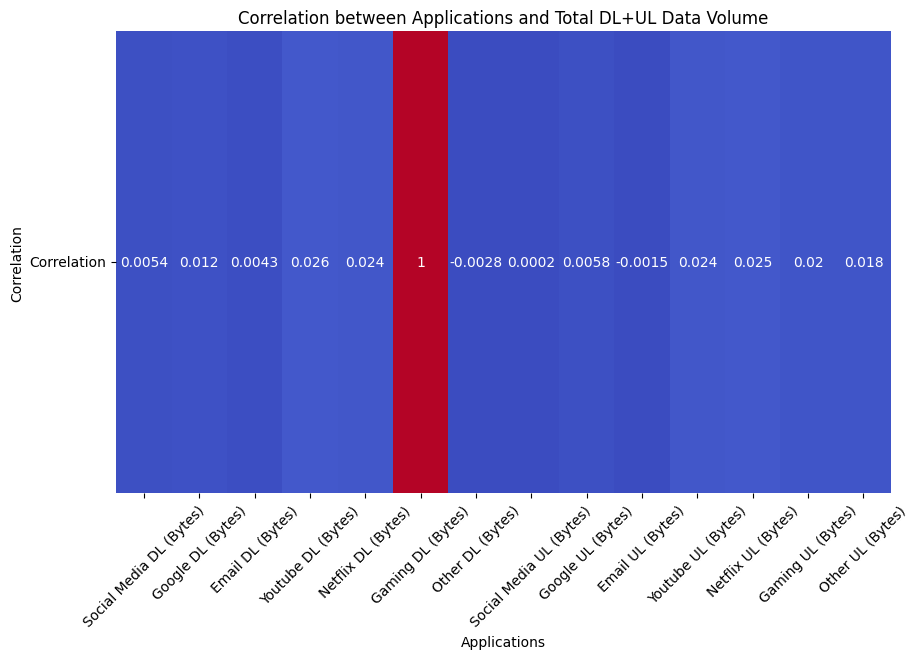

In [19]:
# Convert correlation to DataFrame for plotting
correlation_df = pd.DataFrame(correlation, columns=['Correlation'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df.transpose(), annot=True, cmap='coolwarm', cbar=False)
plt.title('Correlation between Applications and Total DL+UL Data Volume')
plt.xlabel('Applications')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [20]:
# Calculate total duration for all sessions for each user
combined_df['Total Duration (s)'] = (combined_df['Dur. (ms)'] + combined_df['Dur. (ms).1']) / 1000

# Group by MSISDN/Number (user) and calculate the total duration
user_total_duration = combined_df.groupby('MSISDN/Number')['Total Duration (s)'].sum()

# Segment users into deciles based on total duration
user_total_duration_deciles = pd.qcut(user_total_duration, q=10, labels=False)

# Assign decile class to each user in the original DataFrame
combined_df['Decile Class'] = combined_df['MSISDN/Number'].map(user_total_duration_deciles)

# Compute the total data (DL+UL) for each decile class
total_data_per_decile = combined_df.groupby('Decile Class')[['Total DL (Bytes)', 'Total UL (Bytes)']].sum()

# Compute the total data (DL+UL) in bytes
total_data_per_decile['Total Data (DL+UL)'] = total_data_per_decile['Total DL (Bytes)'] + total_data_per_decile['Total UL (Bytes)']

# Sort the deciles by total data in descending order
total_data_per_decile.sort_values(by='Total Data (DL+UL)', ascending=False, inplace=True)

# Display the result
print("Total data (DL+UL) per decile class:")
print(total_data_per_decile)

Total data (DL+UL) per decile class:
              Total DL (Bytes)  Total UL (Bytes)  Total Data (DL+UL)
Decile Class                                                        
9                 1.411462e+13      1.280285e+12        1.539491e+13
8                 8.536321e+12      7.703095e+11        9.306631e+12
7                 7.169617e+12      6.522444e+11        7.821862e+12
2                 5.965793e+12      5.414028e+11        6.507195e+12
5                 5.892506e+12      5.332956e+11        6.425801e+12
6                 5.646784e+12      5.056942e+11        6.152478e+12
1                 5.604511e+12      5.053914e+11        6.109903e+12
4                 5.378404e+12      4.864862e+11        5.864890e+12
0                 4.989433e+12      4.493515e+11        5.438784e+12
3                 4.898978e+12      4.437611e+11        5.342739e+12


In [21]:
# Select the columns for correlation analysis
selected_columns = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                    'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)',
                    'Other DL (Bytes)']

# Compute the correlation matrix
correlation_matrix = combined_df[selected_columns].corr()

# Interpret the findings
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                         Social Media DL (Bytes)  Google DL (Bytes)  \
Social Media DL (Bytes)                 1.000000          -0.001954   
Google DL (Bytes)                      -0.001954           1.000000   
Email DL (Bytes)                        0.004745          -0.000039   
Youtube DL (Bytes)                     -0.001389           0.001760   
Netflix DL (Bytes)                     -0.001817           0.000548   
Gaming DL (Bytes)                       0.001018          -0.001421   
Other DL (Bytes)                        0.006126          -0.002557   

                         Email DL (Bytes)  Youtube DL (Bytes)  \
Social Media DL (Bytes)          0.004745           -0.001389   
Google DL (Bytes)               -0.000039            0.001760   
Email DL (Bytes)                 1.000000            0.001679   
Youtube DL (Bytes)               0.001679            1.000000   
Netflix DL (Bytes)               0.001351            0.001202   
Gaming DL (Bytes)    

In [30]:
# Define numerical columns
numerical_cols = [
    'Bearer Id', 'Start ms', 'End ms', 'Dur. (ms)', 'IMSI', 'MSISDN/Number', 'IMEI',
    'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
    'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)',
    '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
    'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)',
    'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
    'Activity Duration UL (ms)', 'Dur. (ms).1', 'Nb of sec with 125000B < Vol DL',
    'Nb of sec with 1250B < Vol UL < 6250B', 'Nb of sec with 31250B < Vol DL < 125000B',
    'Nb of sec with 6250B < Vol DL < 31250B', 'Nb of sec with Vol DL < 6250B',
    'Nb of sec with Vol UL < 1250B', 'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)', 'Email UL (Bytes)',
    'Youtube DL (Bytes)', 'Youtube UL (Bytes)', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)',
    'Total UL (Bytes)', 'Total DL (Bytes)', 'Total Duration (s)'
]

# Define categorical columns
categorical_cols = ['Start', 'End', 'Last Location Name', 'Handset Manufacturer', 'Handset Type']


In [31]:
# Define preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Standardize numerical features
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),  # Apply numerical preprocessing
        ('cat', categorical_transformer, categorical_cols)  # Apply categorical preprocessing
    ])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_preprocessed = pipeline.fit_transform(combined_df)


In [35]:

# Define PCA pipeline with integer value for n_components
pca_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing steps (already defined)
    ('pca', PCA(n_components=50, svd_solver='arpack'))   # Specify an integer value for n_components
])

# Fit and transform the data using the PCA pipeline
X_pca = pca_pipeline.fit_transform(combined_df)

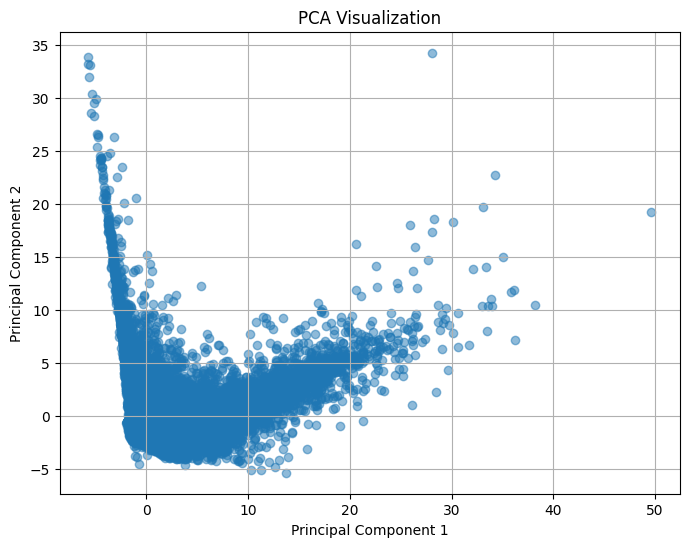

In [36]:
# Scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

Additions to check this codes*

In [ ]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(combined_df)

# Extract explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Extract principal component loadings
loadings = pca.components_

# Print explained variance ratios
print("Explained Variance Ratios:")
for i, ratio in enumerate(explained_variance_ratios):
    print(f"PC{i+1}: {ratio:.2%}")

# Print principal component loadings
print("\nPrincipal Component Loadings:")
for i, pc in enumerate(loadings):
    print(f"PC{i+1}: {', '.join([f'{feature}: {loading:.2f}' for feature, loading in zip(combined_df.columns, pc)])}")


In [ ]:
# Get the absolute values of the loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame to store the loadings
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=combined_df.columns)

# Sort features by the absolute values of their loadings in PC1 and PC2
sorted_loadings_df = loadings_df.abs().sort_values(by=['PC1', 'PC2'], ascending=False)

# Print the top features contributing to PC1 and PC2
print("Top features contributing to PC1:")
print(sorted_loadings_df['PC1'].head())
print("\nTop features contributing to PC2:")
print(sorted_loadings_df['PC2'].head())